In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os

import scipy.stats as stats
import warnings

from matplotlib import pyplot as plt
from dotenv import load_dotenv
from sklearn import preprocessing

from scripts.cleaning import remove_outliers, scale_df

load_dotenv()
plt.style.use('Solarize_Light2')
sns.color_palette("colorblind")

warnings.filterwarnings('ignore')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

pc_dpi = int(os.getenv('DPI'))

if pc_dpi is None:
    pc_dpi = 100

# Override max dpi

if pc_dpi > 155:
    pc_dpi = 155


In [2]:
# File

sea_ds = "./data/seattle_data.csv"

df_seattle = pd.read_csv(sea_ds)


In [3]:
df_seattle.shape


(1099, 22)

# <u>Analyse exploratoire :</u>

## <u>0. Elimination d'aberrations via IQR</u>

## <u>1. Age des batiments </u>
- <u>1.a : Représentation des batiments en fonction de leurs dates de construction. </u>
- <u>1.b : Visualisation des statistiques principales de la variable : Energie par metre carré </u>
- <u>1.c : Paire 1.a 1.b : Date de construction et utilisation en energie par metre carré | Emission de GES par m2. </u>

<hr>

## <u> 2. Etude de la note Energy Star</u>
- <u> 2.a : Repartition de la note Energy Star au sein des données. </u>
- <u> 2.b : Paire 2 : Note Energy Star en fonction de l'energie par metre carré. </u>
- <u> 2.c : Paire 3 : Note Energy Star en fonction de l'intensité d'emissions de GES. </u>
- <u> 2.d : Paire 4 : Energy Star en fonction de l'année de construction. </u>

<hr>

## <u> 3 : Représentation Property Type/Utilisation Energie </u>
- <u> 3.a : Visualisation des categories principales </u>
- <u> 3.b : Etude en détails de la correllation taille -> E* </u>
- <u> 3.c : Etude en détails de la correllation taille -> GES </u>
- <u> 3.d : Etude en détails de la correllation taille -> EUI </u>

### One Hot Encoding des variables categorielles utiles
### Export 1 : dataset destine a la prediction EUI et GES
_note_ : _Données non standardisées et encodées_
### Cette analyse permettra de :
 - Visualiser "l'age" du paysage de Seattle
 - Contextualiser la mesure de la consommation d'énergie au metre carré, et sa possible relation avec l'age des batiments
 - Avoir une meilleure comprehension de la variable Energy Star et de la présenter face à l'age des batiments et de leur consommation en energie


## 0. Elimination d'outliers via la methode interquartile :


In [4]:
cleaning_list = ["Electricity(kWh)", "SourceEUI(kWh/m2)", "SiteEnergyUse(kWh)"]

for col in cleaning_list:
    remove_outliers(col, df_seattle)

print(df_seattle.shape)

print(f"{1099 - df_seattle.shape[0]} buildings deleted")


(868, 22)
231 buildings deleted


## 1. Age des batiments

### 1.a : Représentation des batiments en fonction de leurs dates de construction.

In [5]:
data_age = list(df_seattle["YearBuilt"].astype(int))
oldest = min(data_age)
youngest = max(data_age)

print(f"Le plus ancien batiment date de {oldest}, le plus récent (donnees de 2016) date de {youngest}")


Le plus ancien batiment date de 1900, le plus récent (donnees de 2016) date de 2015


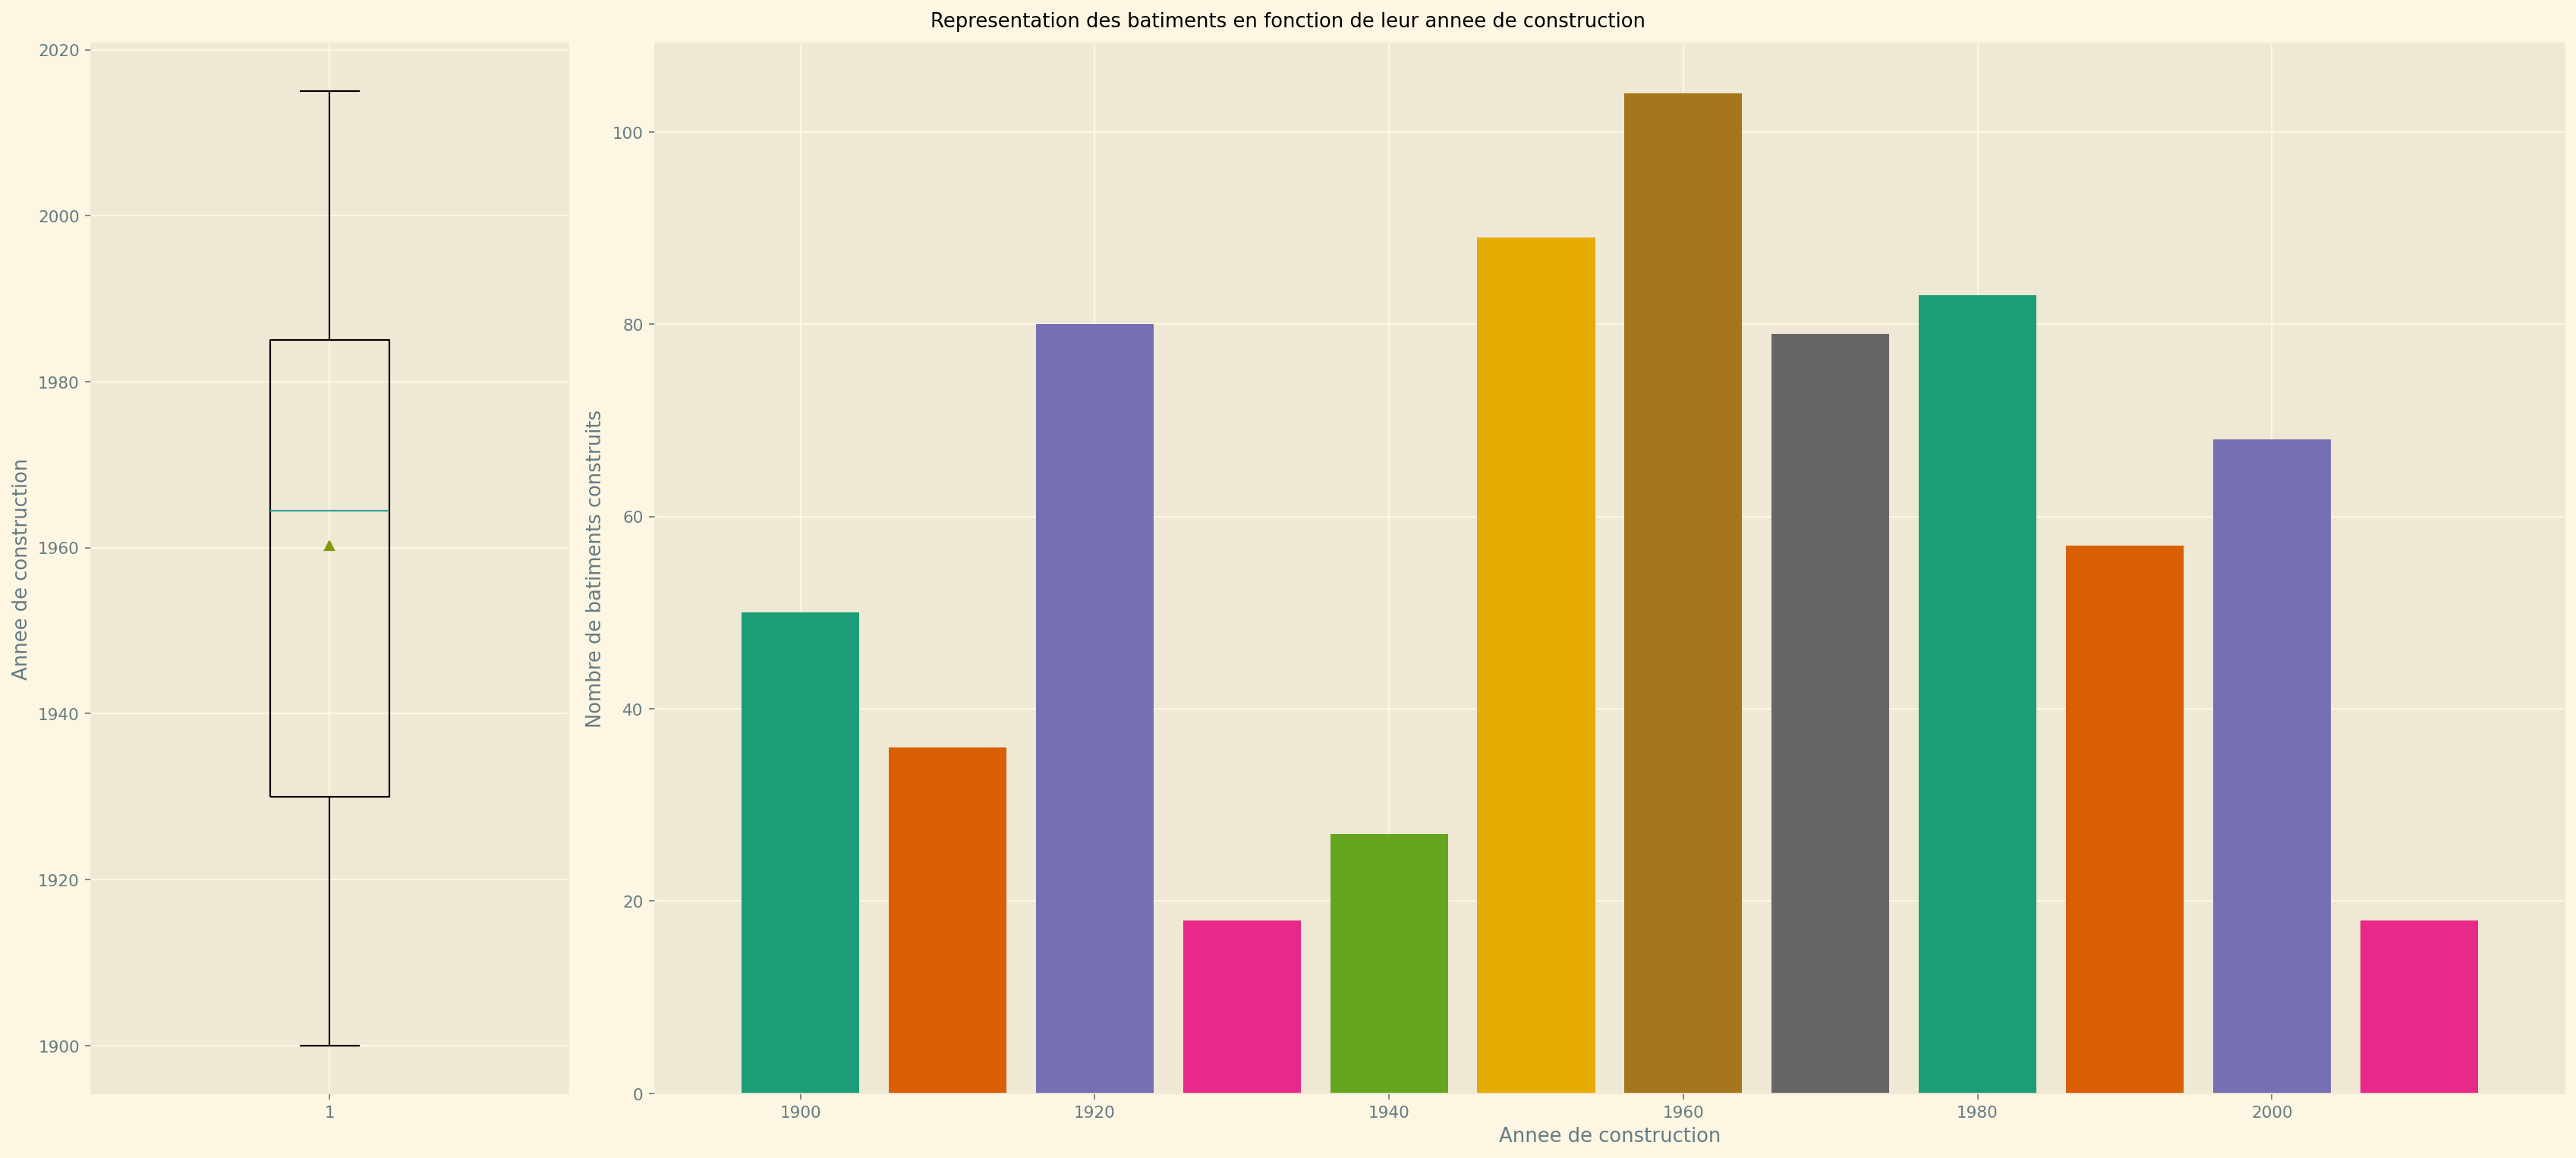

In [6]:
decades = np.arange(1900, 2020, 10)

building_per_decade = dict.fromkeys(decades)

for decade in building_per_decade.keys():
    built = len([year for year in data_age if (year > decade and year < decade + 10)])
    building_per_decade[decade] = built

used_cmap = plt.get_cmap("Dark2")

fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(22, 10),
    gridspec_kw={"width_ratios": [1, 4]},
    dpi=pc_dpi
    )

ax1.boxplot(data_age, showmeans=True, widths=0.25)

ax2.bar(building_per_decade.keys(), height=building_per_decade.values(), width=8, color=used_cmap.colors)

###
# Titles & Labels
ax1.set_ylabel("Annee de construction")
ax2.set_ylabel("Nombre de batiments construits")
ax2.set_xlabel("Annee de construction")
fig.suptitle("Representation des batiments en fonction de leur annee de construction")
fig.tight_layout()
#
###

plt.show()

#### Observations :

- Le paysage urbanin de Seattle date, majoritairement (q1, q3) de 1939 - 1990 (moyenne en 1965)
- On remarque une logique économique : pic de construction dans les années 20 (Roaring 20s) suivi par un creux dans les années 30 (Grande Depression)
- De nombreux projets date de du debut du millénaire, la decenie 2010+ n'est pas étudiable : les données s'arretent en 2015

### 1.b : Visualisation des statistiques principales de la variable : Energie par metre carré

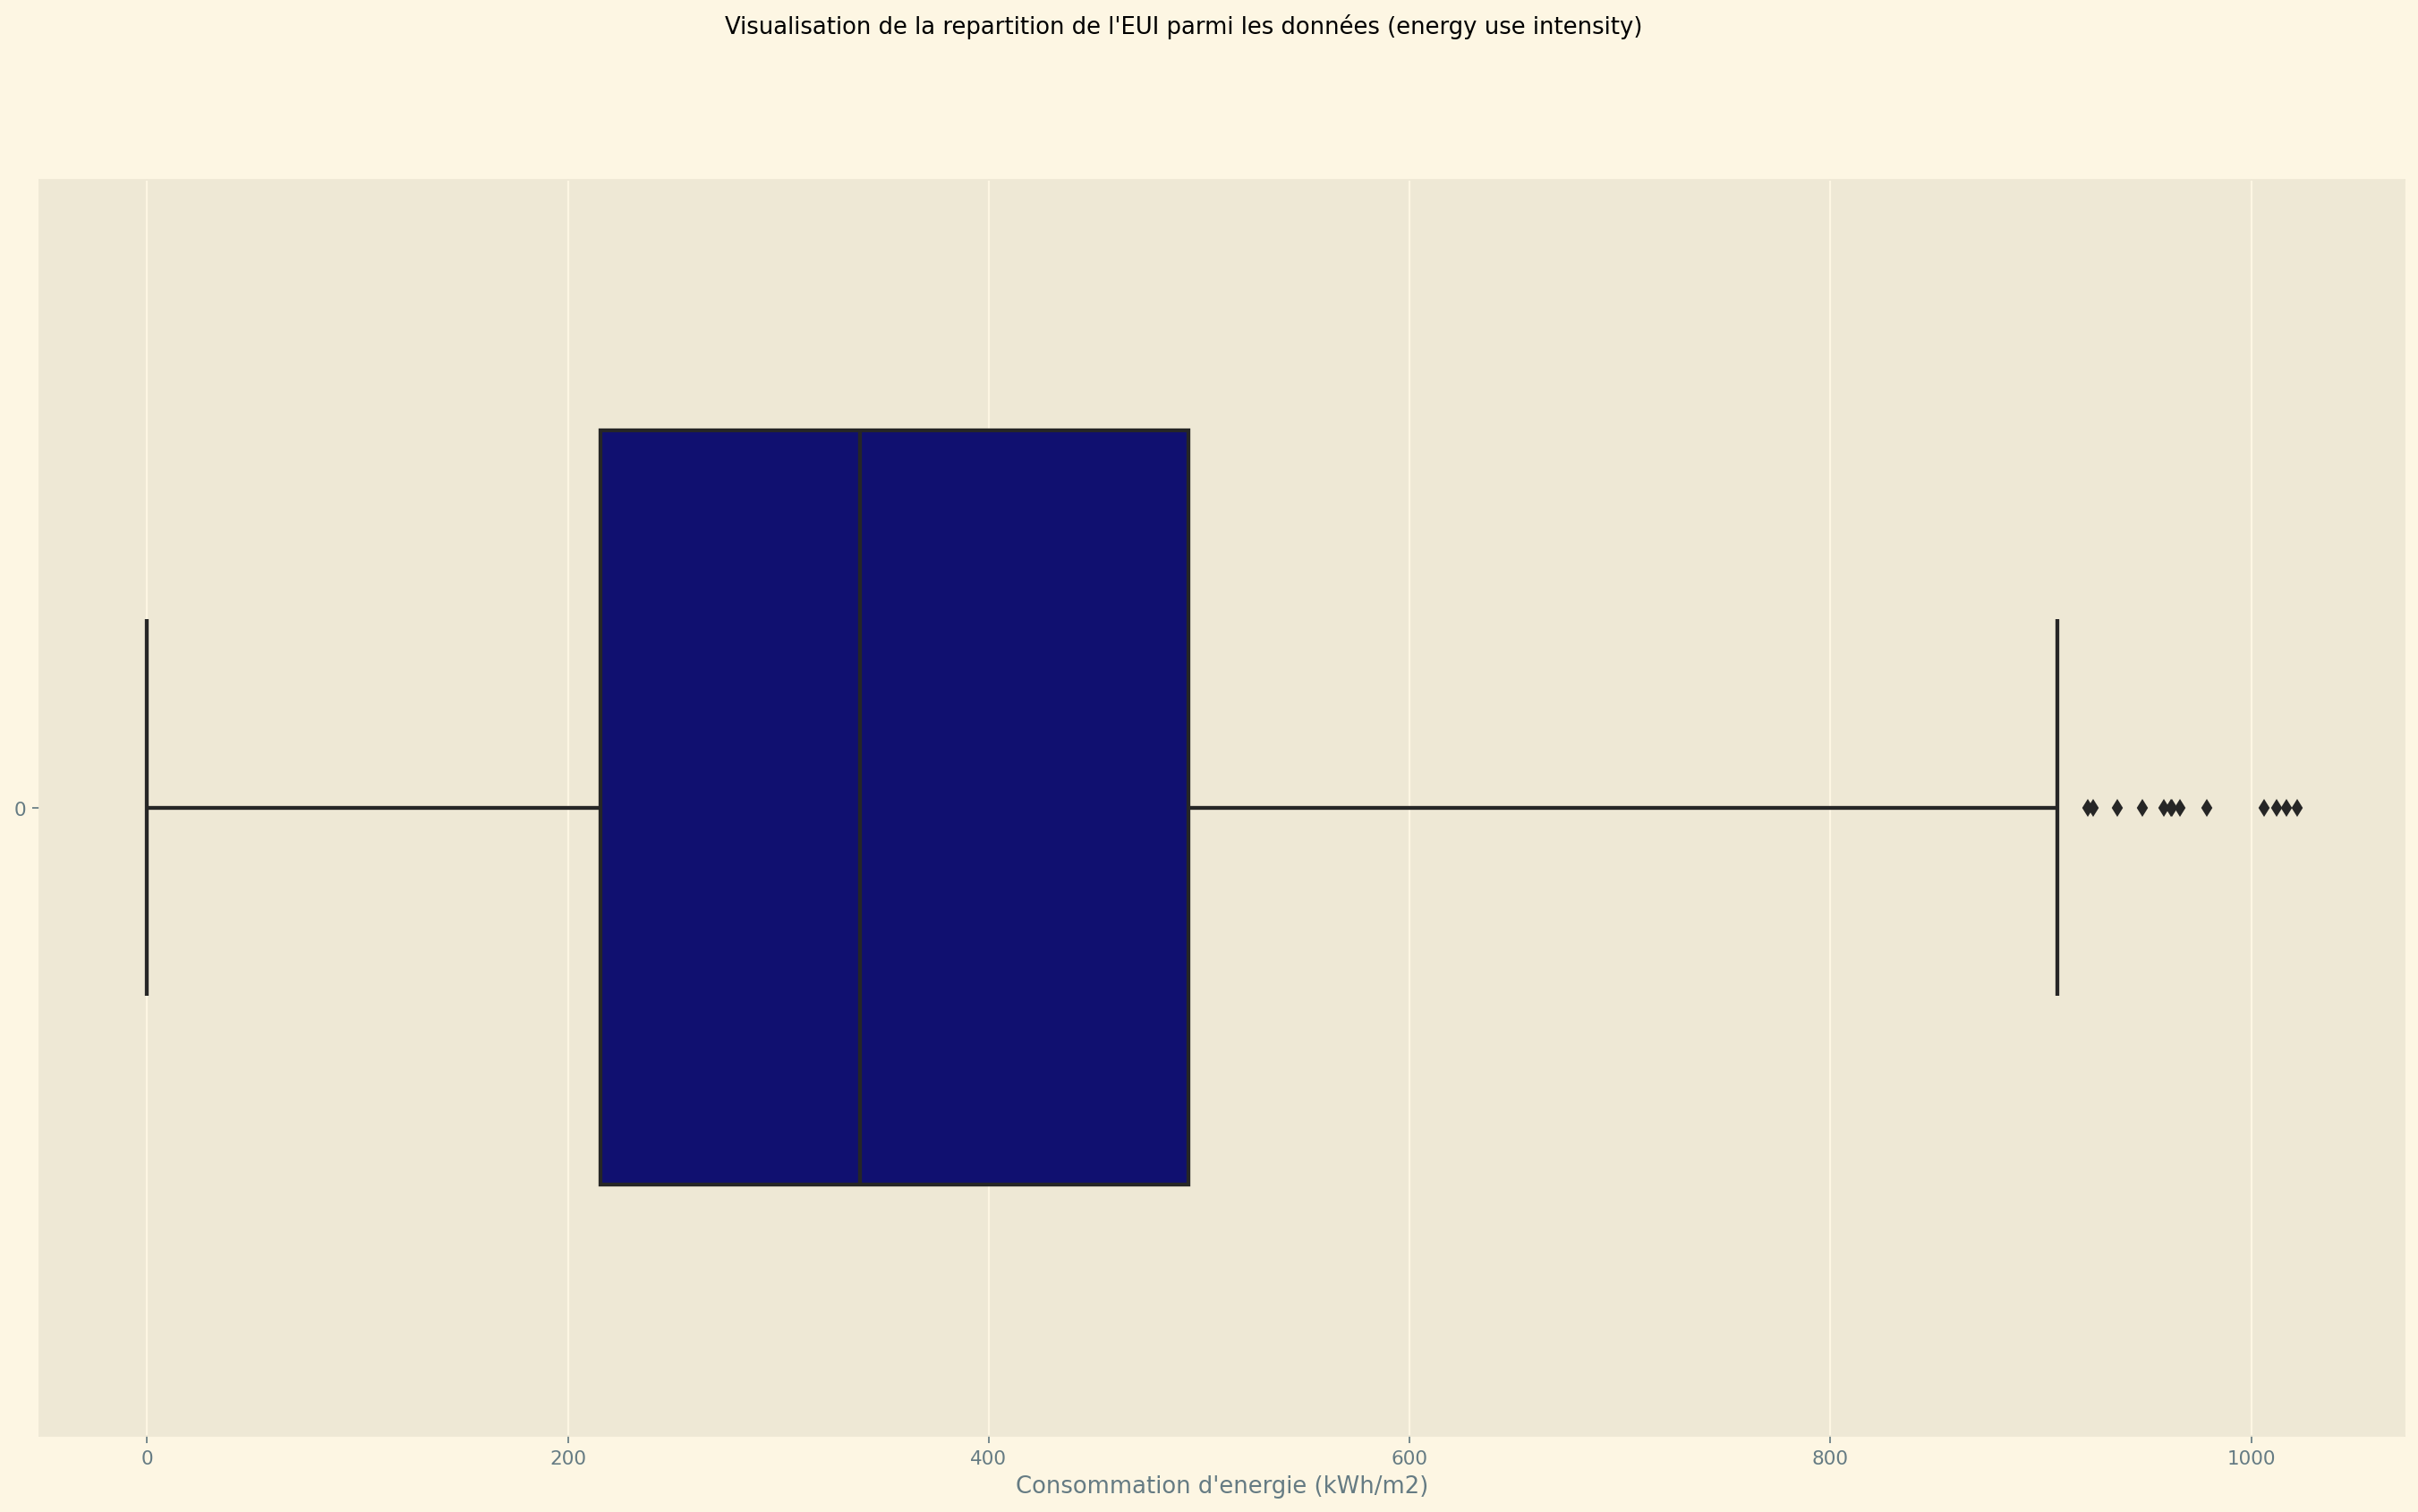

count     868.000000
mean      369.994519
std       203.217937
min         0.000000
25%       215.616228
50%       338.645244
75%       494.797449
max      1021.771682
Name: SourceEUI(kWh/m2), dtype: float64


In [7]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 12),
    dpi=pc_dpi,
    )

source_eui_data = list(df_seattle["SourceEUI(kWh/m2)"].values.astype(float))

ax1 = sns.boxplot(data=source_eui_data, width=0.6, ax=ax1, color="navy", orient="h")


###
# Titles/Lables
ax1.set_xlabel("Consommation d'energie (kWh/m2)")
fig.suptitle("Visualisation de la repartition de l'EUI parmi les données (energy use intensity)")
#
###

plt.show()

print(df_seattle["SourceEUI(kWh/m2)"].astype(float).describe())


#### Analyse :

- 1 : Les outliers sont extrèmement nombreux, uniquement dans les utilisations "hautes"
- 2 : La majorité des batiments ont une EUI entre 215 et 494 kWh/m2, 369 en moyenne.
- 3 : L'élimination de batiments via la methode interquartile peut être viable, la reduction de dimension via ACP peut également être une piste


### 1.c : Paire 1 : Date de construction et EUI | GES/m2

In [8]:
df_seattle.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'LargestPropertyUseType', 'ENERGYSTARScore', 'Electricity(kWh)',
       'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'PropertyArea(SquareMetre)Total', 'PropertyArea(SquareMetre)Parking',
       'PropertyArea(SquareMetre)Building(s)',
       'LargestPropertyUseTypeArea(SquareMetre)', 'SourceEUI(kWh/m2)',
       'SourceEUIWN(kWh/m2)', 'SiteEnergyUse(kWh)', 'SiteEnergyUseWN(kWh)',
       'NaturalGas(kWh)'],
      dtype='object')

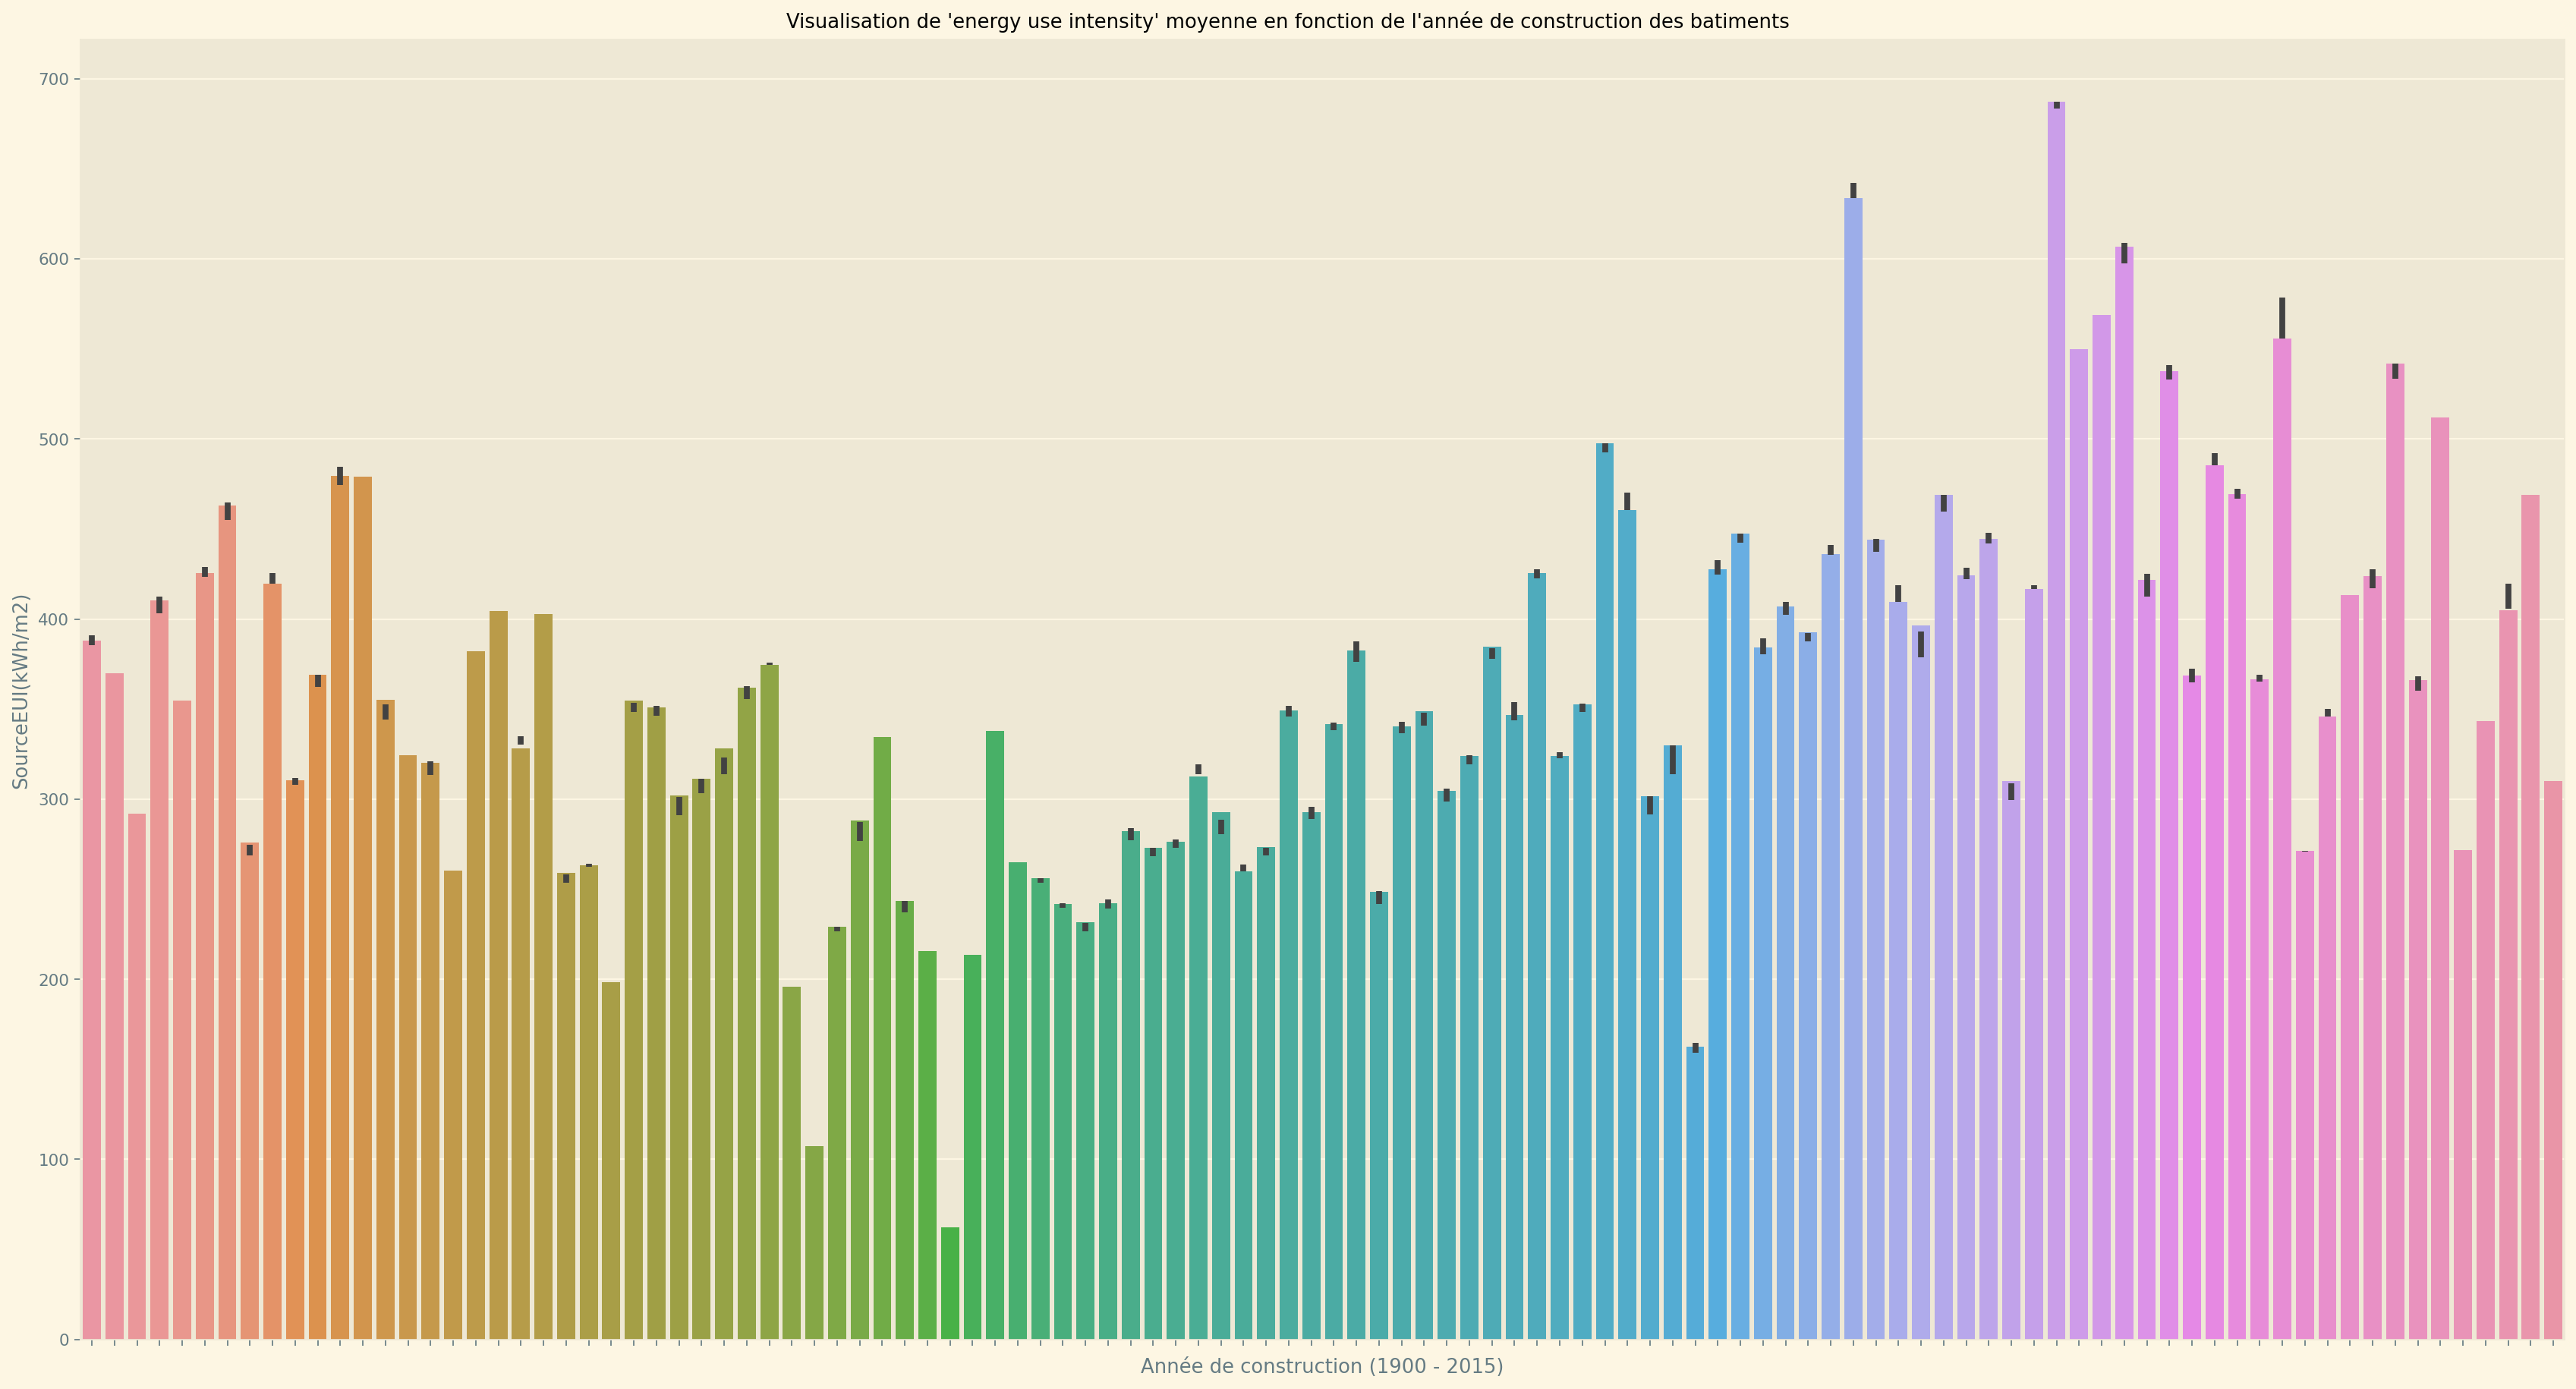

In [9]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 12),
    dpi=pc_dpi,
)

ax1 = sns.barplot(
    x=df_seattle["YearBuilt"].astype(int).values,
    y=df_seattle["SourceEUI(kWh/m2)"].values.astype(float),
    ci=5
)

###
# Titles/Lables
ax1.set_xticklabels([])
ax1.set_ylabel("SourceEUI(kWh/m2)")
ax1.set_xlabel("Année de construction (1900 - 2015)")
fig.suptitle("Visualisation de 'energy use intensity' moyenne en fonction de l'année de construction des batiments")

#
###
fig.tight_layout()
plt.show()


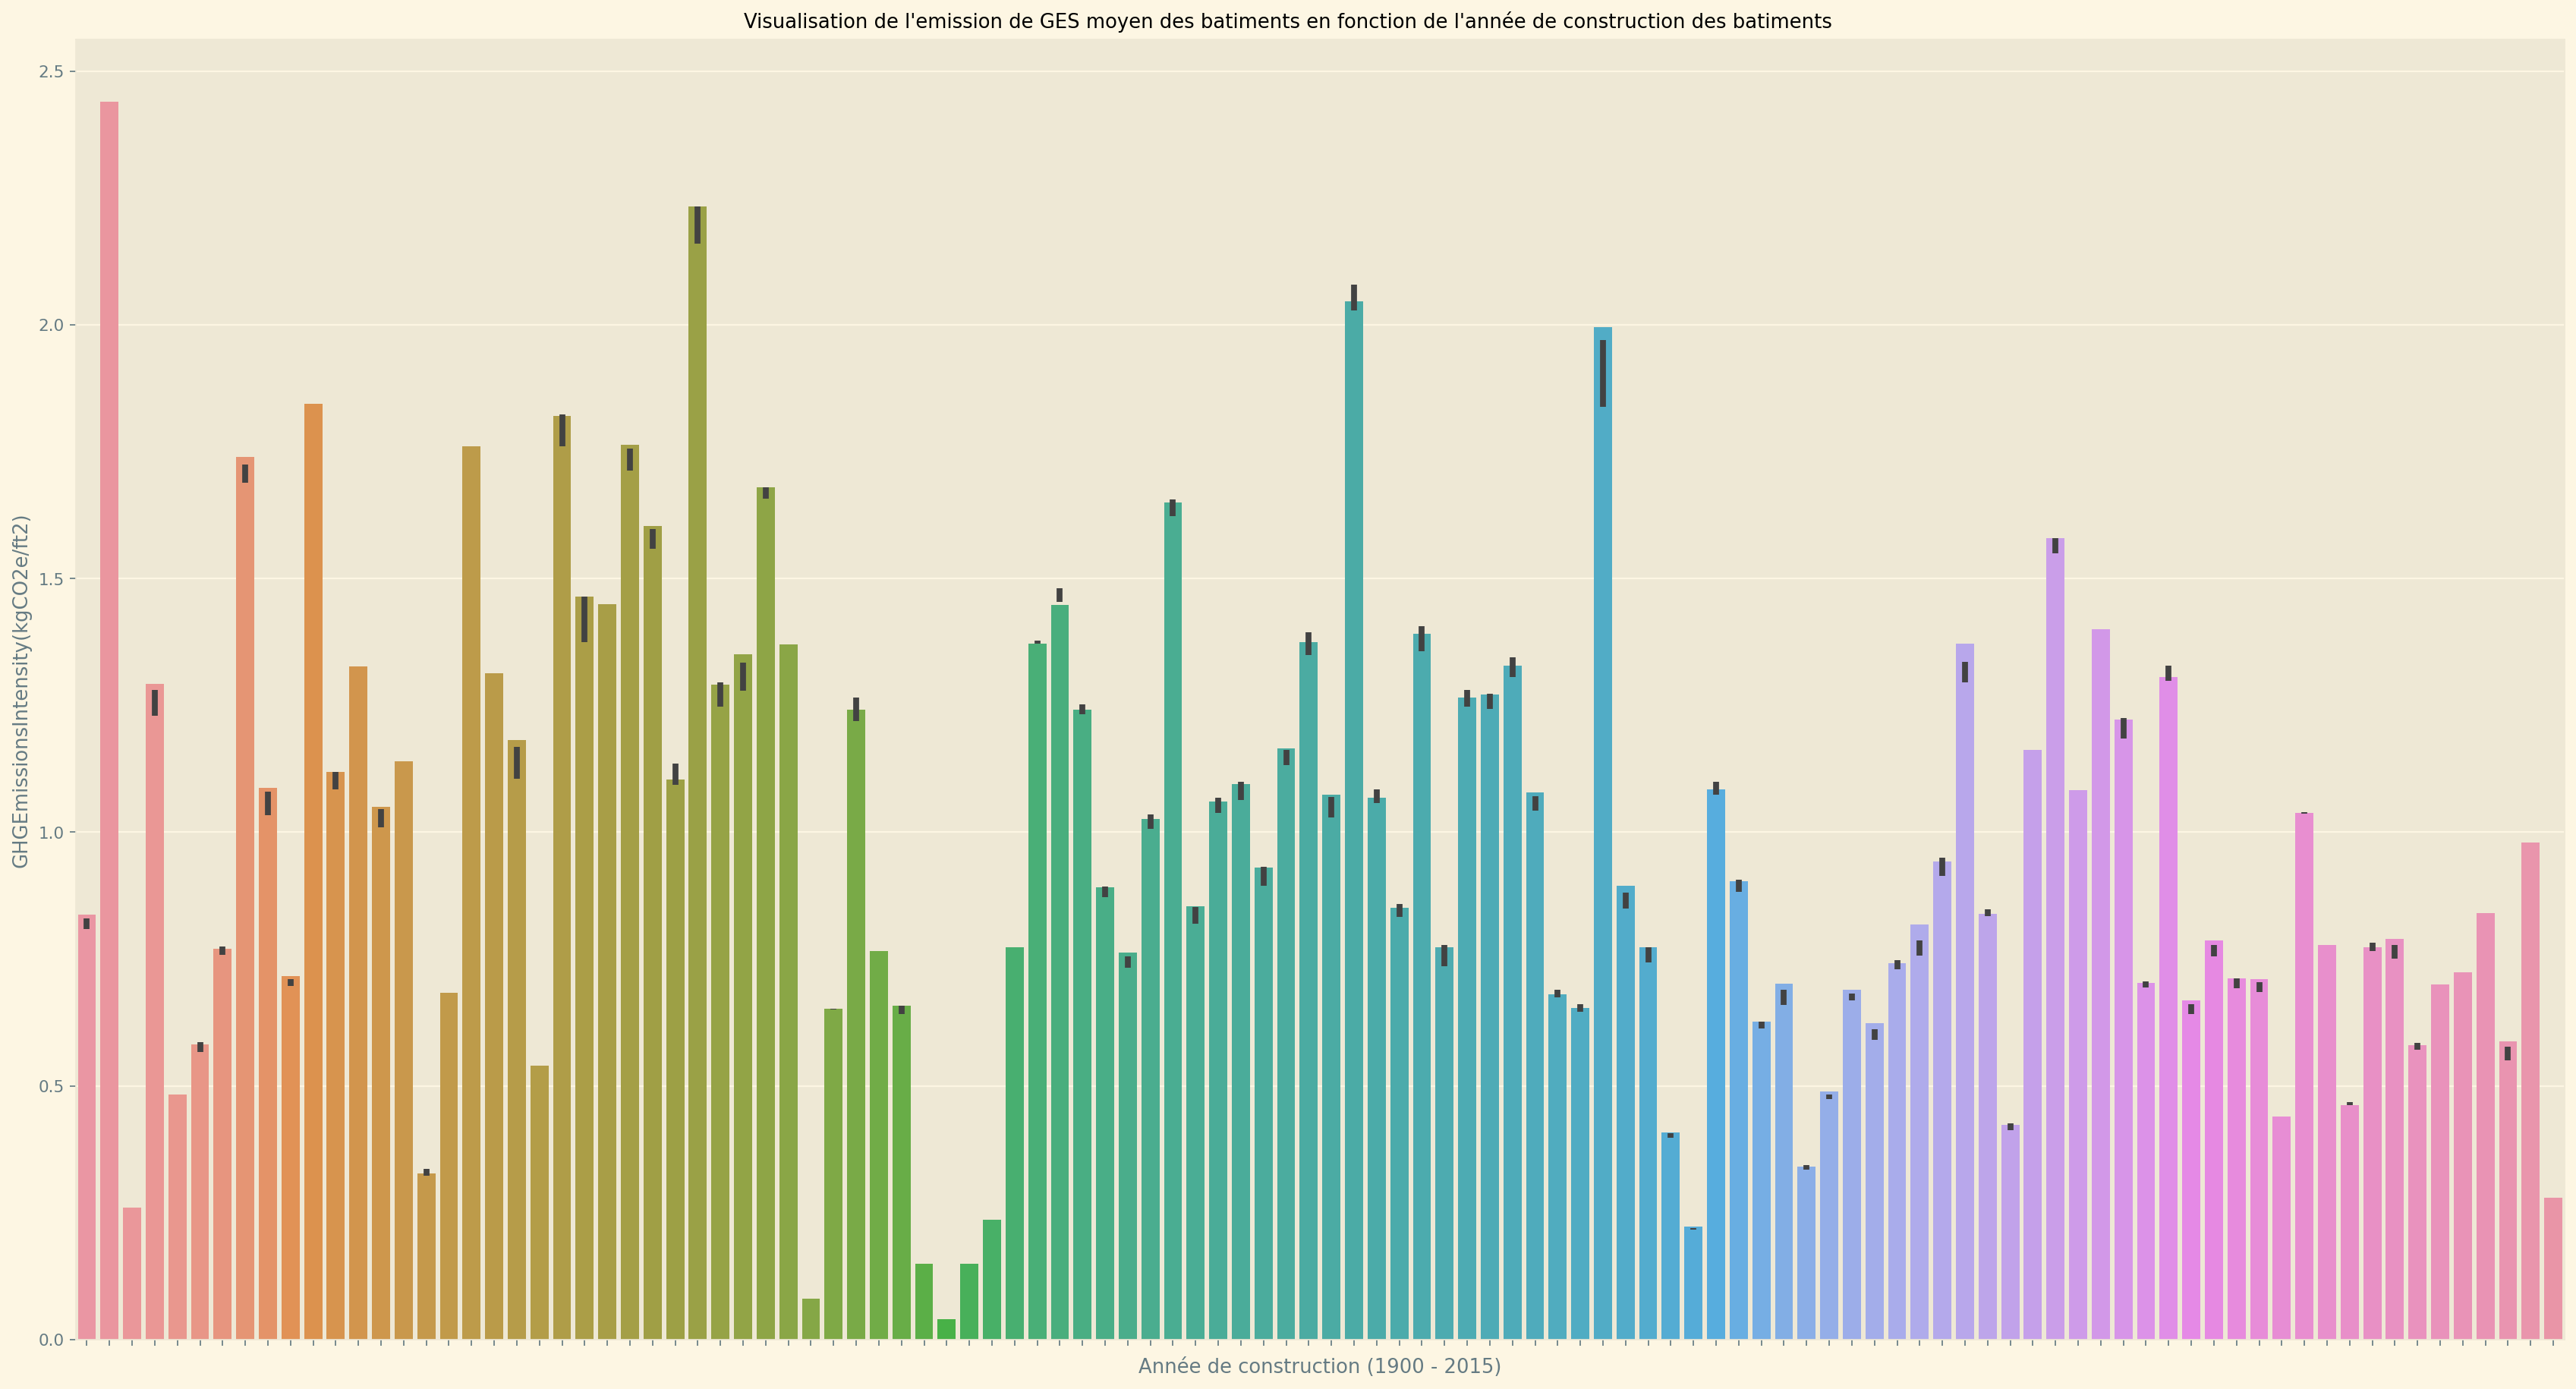

In [10]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 12),
    dpi=pc_dpi,
)

ax1 = sns.barplot(
    x=df_seattle["YearBuilt"].astype(int).values,
    y=df_seattle["GHGEmissionsIntensity(kgCO2e/ft2)"].values.astype(float),
    ci=5
)

###
# Titles/Lables
ax1.set_xticklabels([])
ax1.set_ylabel("GHGEmissionsIntensity(kgCO2e/ft2)")
ax1.set_xlabel("Année de construction (1900 - 2015)")
fig.suptitle("Visualisation de l'emission de GES moyen des batiments\
 en fonction de l'année de construction des batiments")
#
###
fig.tight_layout()
plt.show()


#### Observation : 
- L'age des batiments ne semble pas avoir d'impact sur leur intensité d'utilisation énergétique. On peut emettre l'hypothèse que les batiments les plus anciens ont été modernisés pour avoir une consommation energetique plus responsable.
- Les batiments les plus modernes semblent rejetter moins de GES que les batiments plus anciens (nouveaux materiaux ? nouvelles techniques de construction ?)

## 2. Etude de la note Energy Star

### 2.a : Repartition de la note Energy Star au sein des données


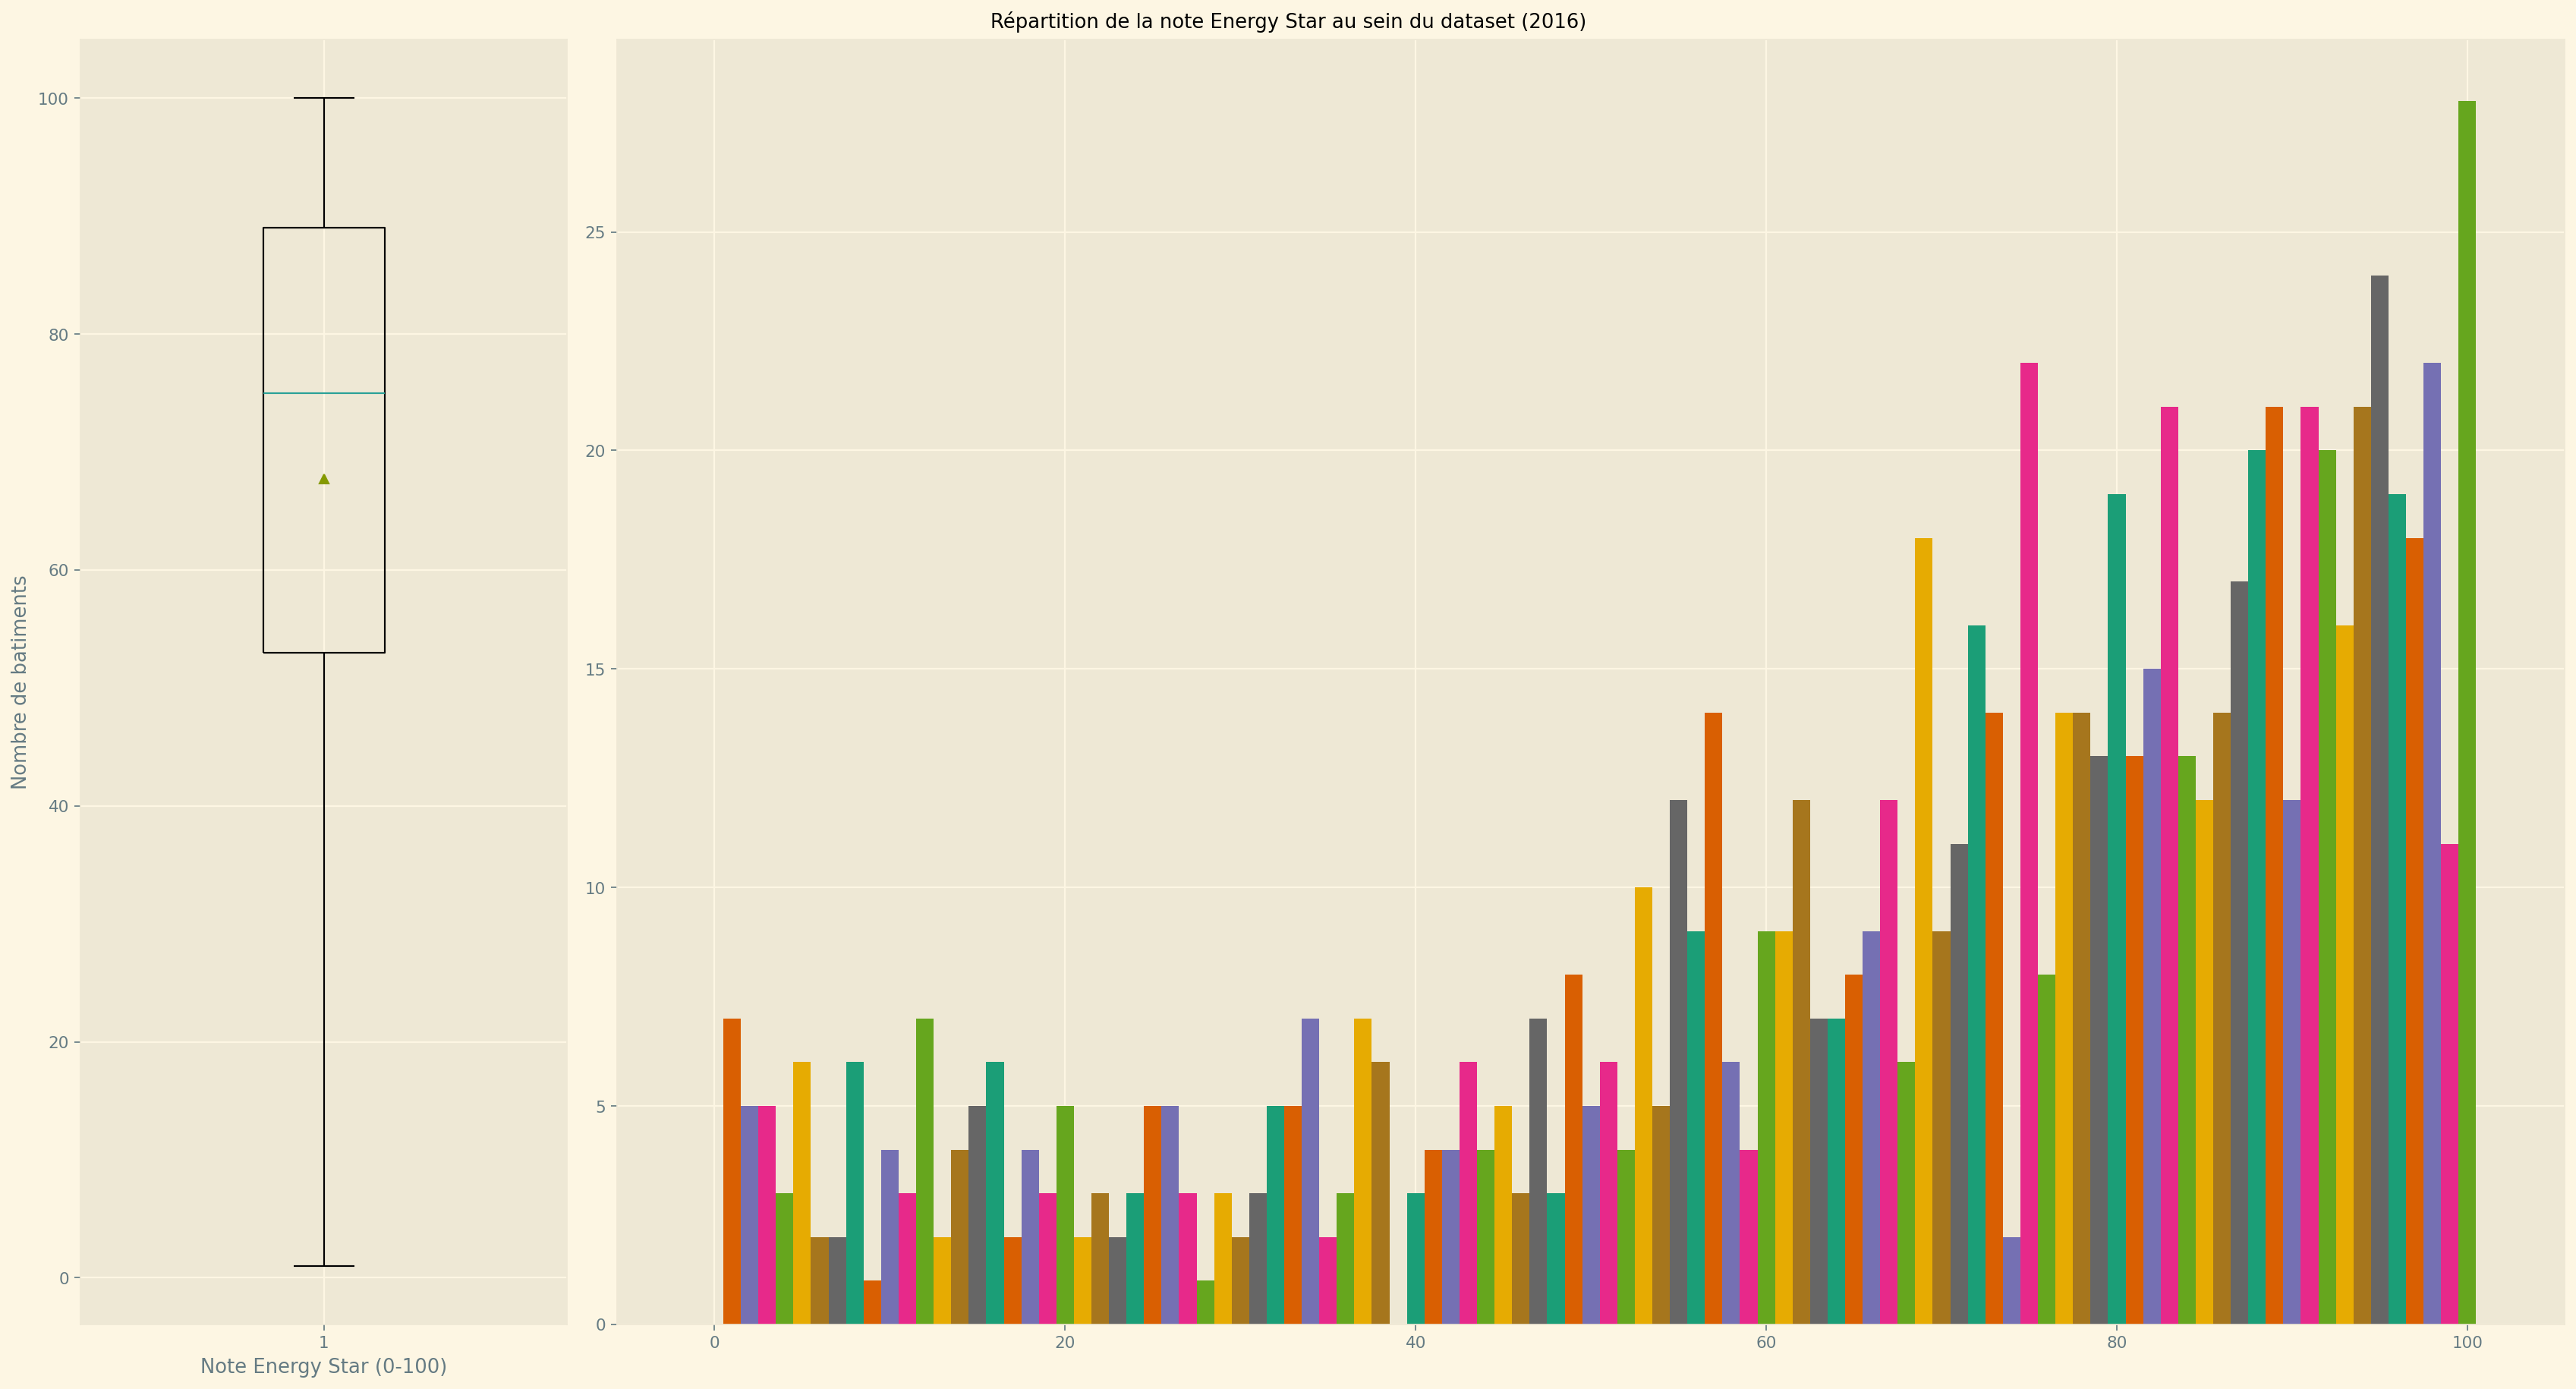

count    868.000000
mean      67.682028
std       26.878046
min        1.000000
25%       53.000000
50%       75.000000
75%       89.000000
max      100.000000
Name: ENERGYSTARScore, dtype: float64

In [11]:
fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(22, 12),
    gridspec_kw={"width_ratios": [1, 4]},
    dpi=pc_dpi,
)

rated = df_seattle[df_seattle["ENERGYSTARScore"].notna()]
scores = list(rated["ENERGYSTARScore"].astype(int).values)
score_range = range(0, 101, 1)
scores_dict = dict.fromkeys(score_range)

for score in scores_dict.keys():
    scores_dict[score] = scores.count(score)

ax1.boxplot(scores, showmeans=True, widths=0.25)

ax2.bar(
    x=list(scores_dict.keys()),
    height=list(scores_dict.values()),
    color=used_cmap.colors,
    width=1
    )

####
## Titles/Lables
ax1.set_ylabel("Nombre de batiments")
ax1.set_xlabel("Note Energy Star (0-100)")
fig.suptitle("Répartition de la note Energy Star au sein du dataset (2016)")
##
####

fig.tight_layout()

plt.show()

rated["ENERGYSTARScore"].describe()


#### Observations :
- Les notes sont globalement hautes (Q1=53-Q3=89) - Les batiments ont le droit d'afficher le label "Energy Star Certified" si leur note est superieure ou égale a 75 -> Mediane (sources), motivation pour chercher a atteindre ce score.
- Variance haute (26).

### 2.b : Paire 2 : Note Energy Star en fonction de l'energie par metre carré.

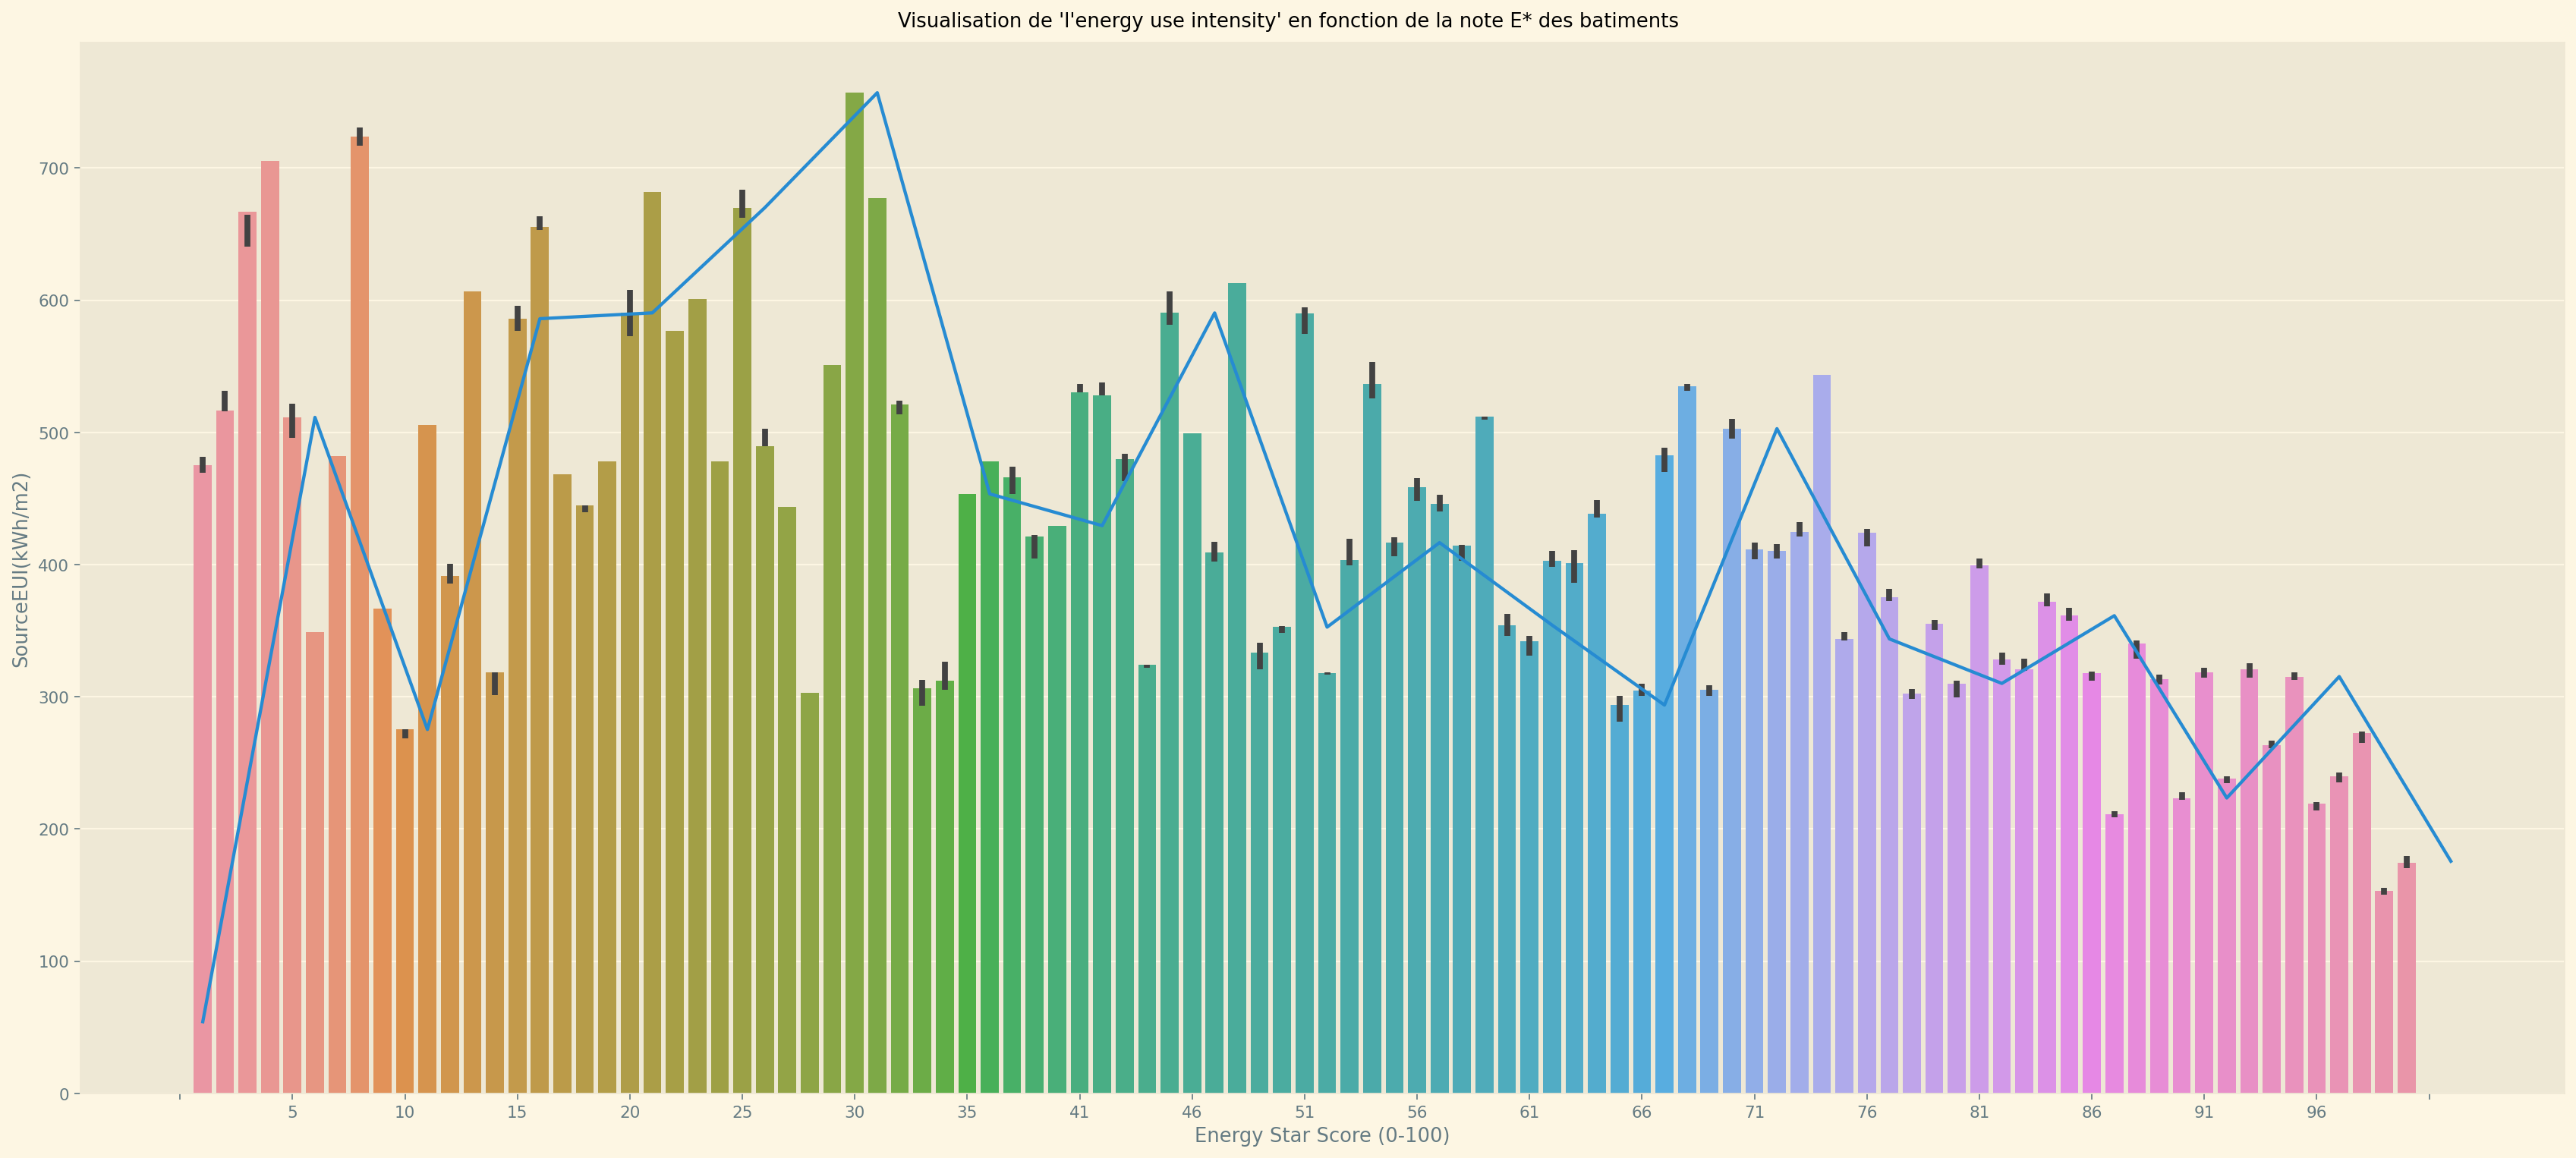

In [12]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 10),
    dpi=pc_dpi,
)

ax1 = sns.barplot(
    x=rated["ENERGYSTARScore"].values.astype(int),
    y=rated["SourceEUI(kWh/m2)"].values.astype(float),
    ci=10
)

x_line = np.arange(0, 101, 5)

y_line = []

for x in x_line:
    ratings_x = rated[rated["ENERGYSTARScore"] == x]
    mean_x = ratings_x["SourceEUI(kWh/m2)"].mean(numeric_only=None)
    if pd.isna(mean_x):
        mean_x = rated["ENERGYSTARScore"].quantile(0.25).mean()
    y_line.append(mean_x)

ax1.plot(x_line, y_line)

###
# Titles/Lables
ax1.set_xticks(np.arange(-1, 101, 5))
ax1.set_ylabel("SourceEUI(kWh/m2)")
ax1.set_xlabel("Energy Star Score (0-100)")
fig.suptitle("Visualisation de 'l'energy use intensity' en fonction de la note E* des batiments")
#
###

fig.tight_layout()
plt.show()


#### Observation 
- On peut observer ici un lien clair entre le Score Energy Star (E*) et l'intensité d'utilisation énergétique (EUI). Le lien est logique dans ce cas : le site E* explique que, entre autres, l'utilisation d'énergie est un facteur.
- Le site internet d'E* fourni également une motivation pour l'obtention de cette note : un batiment est "Energy Star Certified" lorsque sa note est supérieure ou égale à 75 (ce qui peut expliquer le pic autour de cette note : les developpeurs immobiliers ont interèt à obtenir cette certification)

### 2.c : Paire 3 : Note Energy Star en fonction de l'intensité d'emissions de GES.

In [13]:
rated.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'LargestPropertyUseType', 'ENERGYSTARScore', 'Electricity(kWh)',
       'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'PropertyArea(SquareMetre)Total', 'PropertyArea(SquareMetre)Parking',
       'PropertyArea(SquareMetre)Building(s)',
       'LargestPropertyUseTypeArea(SquareMetre)', 'SourceEUI(kWh/m2)',
       'SourceEUIWN(kWh/m2)', 'SiteEnergyUse(kWh)', 'SiteEnergyUseWN(kWh)',
       'NaturalGas(kWh)'],
      dtype='object')

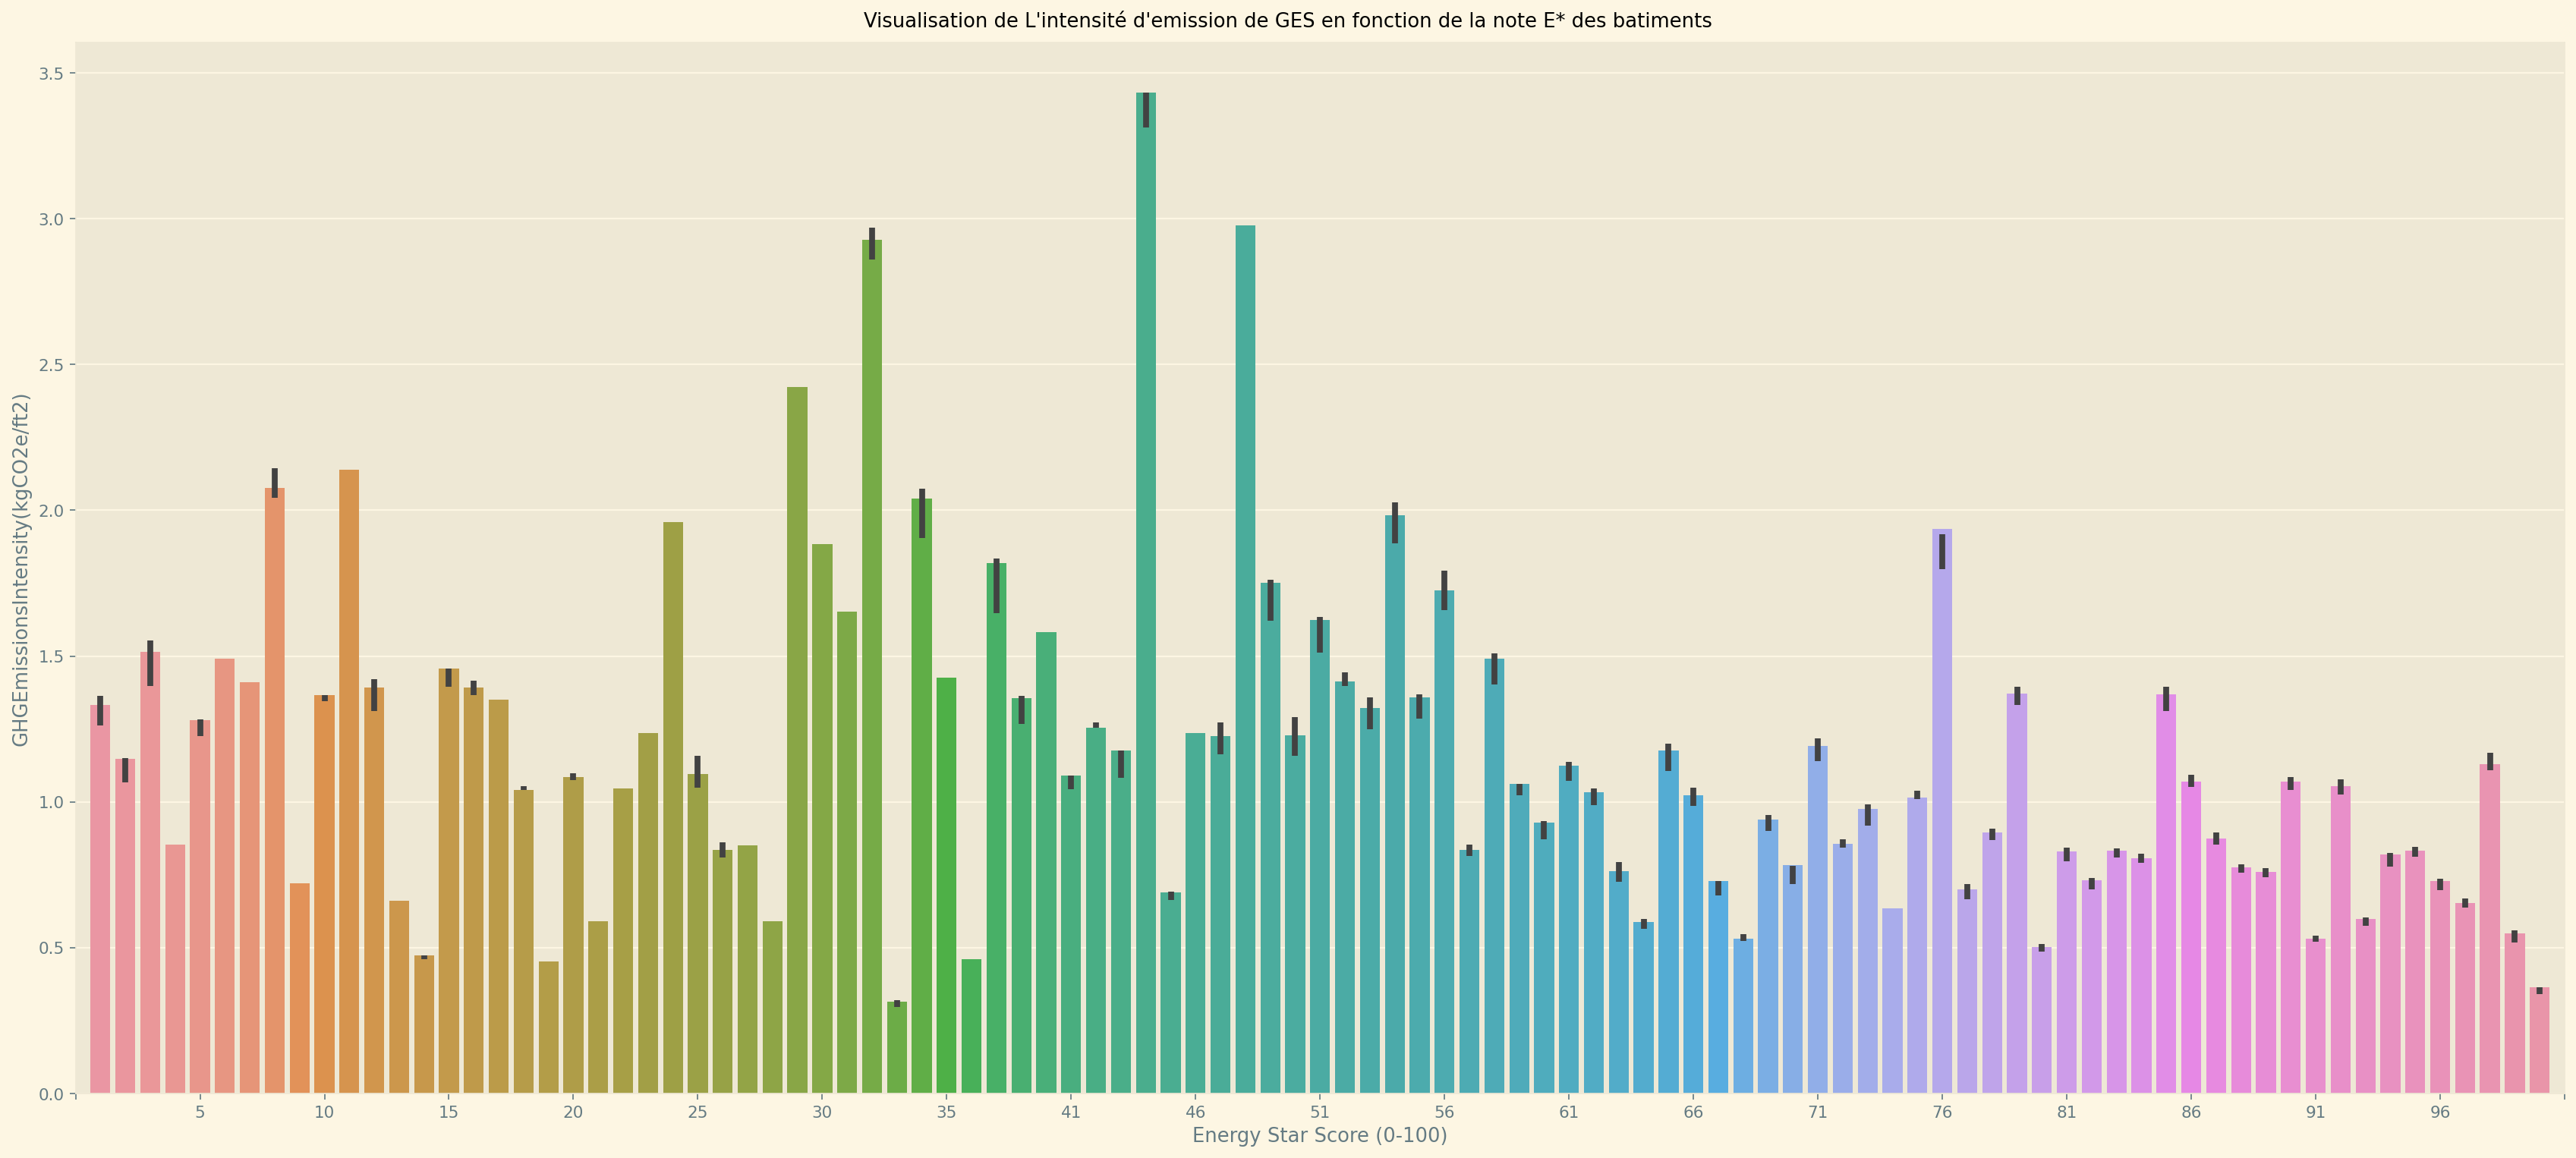

In [14]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 10),
    dpi=pc_dpi,
)

ax1 = sns.barplot(
    x=rated["ENERGYSTARScore"].values.astype(int),
    y=rated["GHGEmissionsIntensity(kgCO2e/ft2)"].values.astype(float),
    ci=10
)

###
# Titles/Lables
ax1.set_xticks(np.arange(-1, 101, 5))
ax1.set_ylabel("GHGEmissionsIntensity(kgCO2e/ft2)")
ax1.set_xlabel("Energy Star Score (0-100)")
fig.suptitle("Visualisation de L'intensité d'emission de GES en fonction de la note E* des batiments")
#
###

fig.tight_layout()
plt.show()


#### Observations :
- Les batiments les mieux notés ont une faible intensite d emission de GES, meme si cela ne semble pas etre systematique (note: 31 -> 56)
- Cela ne semble pas etre le seul facteur mais peu tout de meme distinguer une tendance

### 2.c Paire 4 : Rapport entre E* et année de construction :


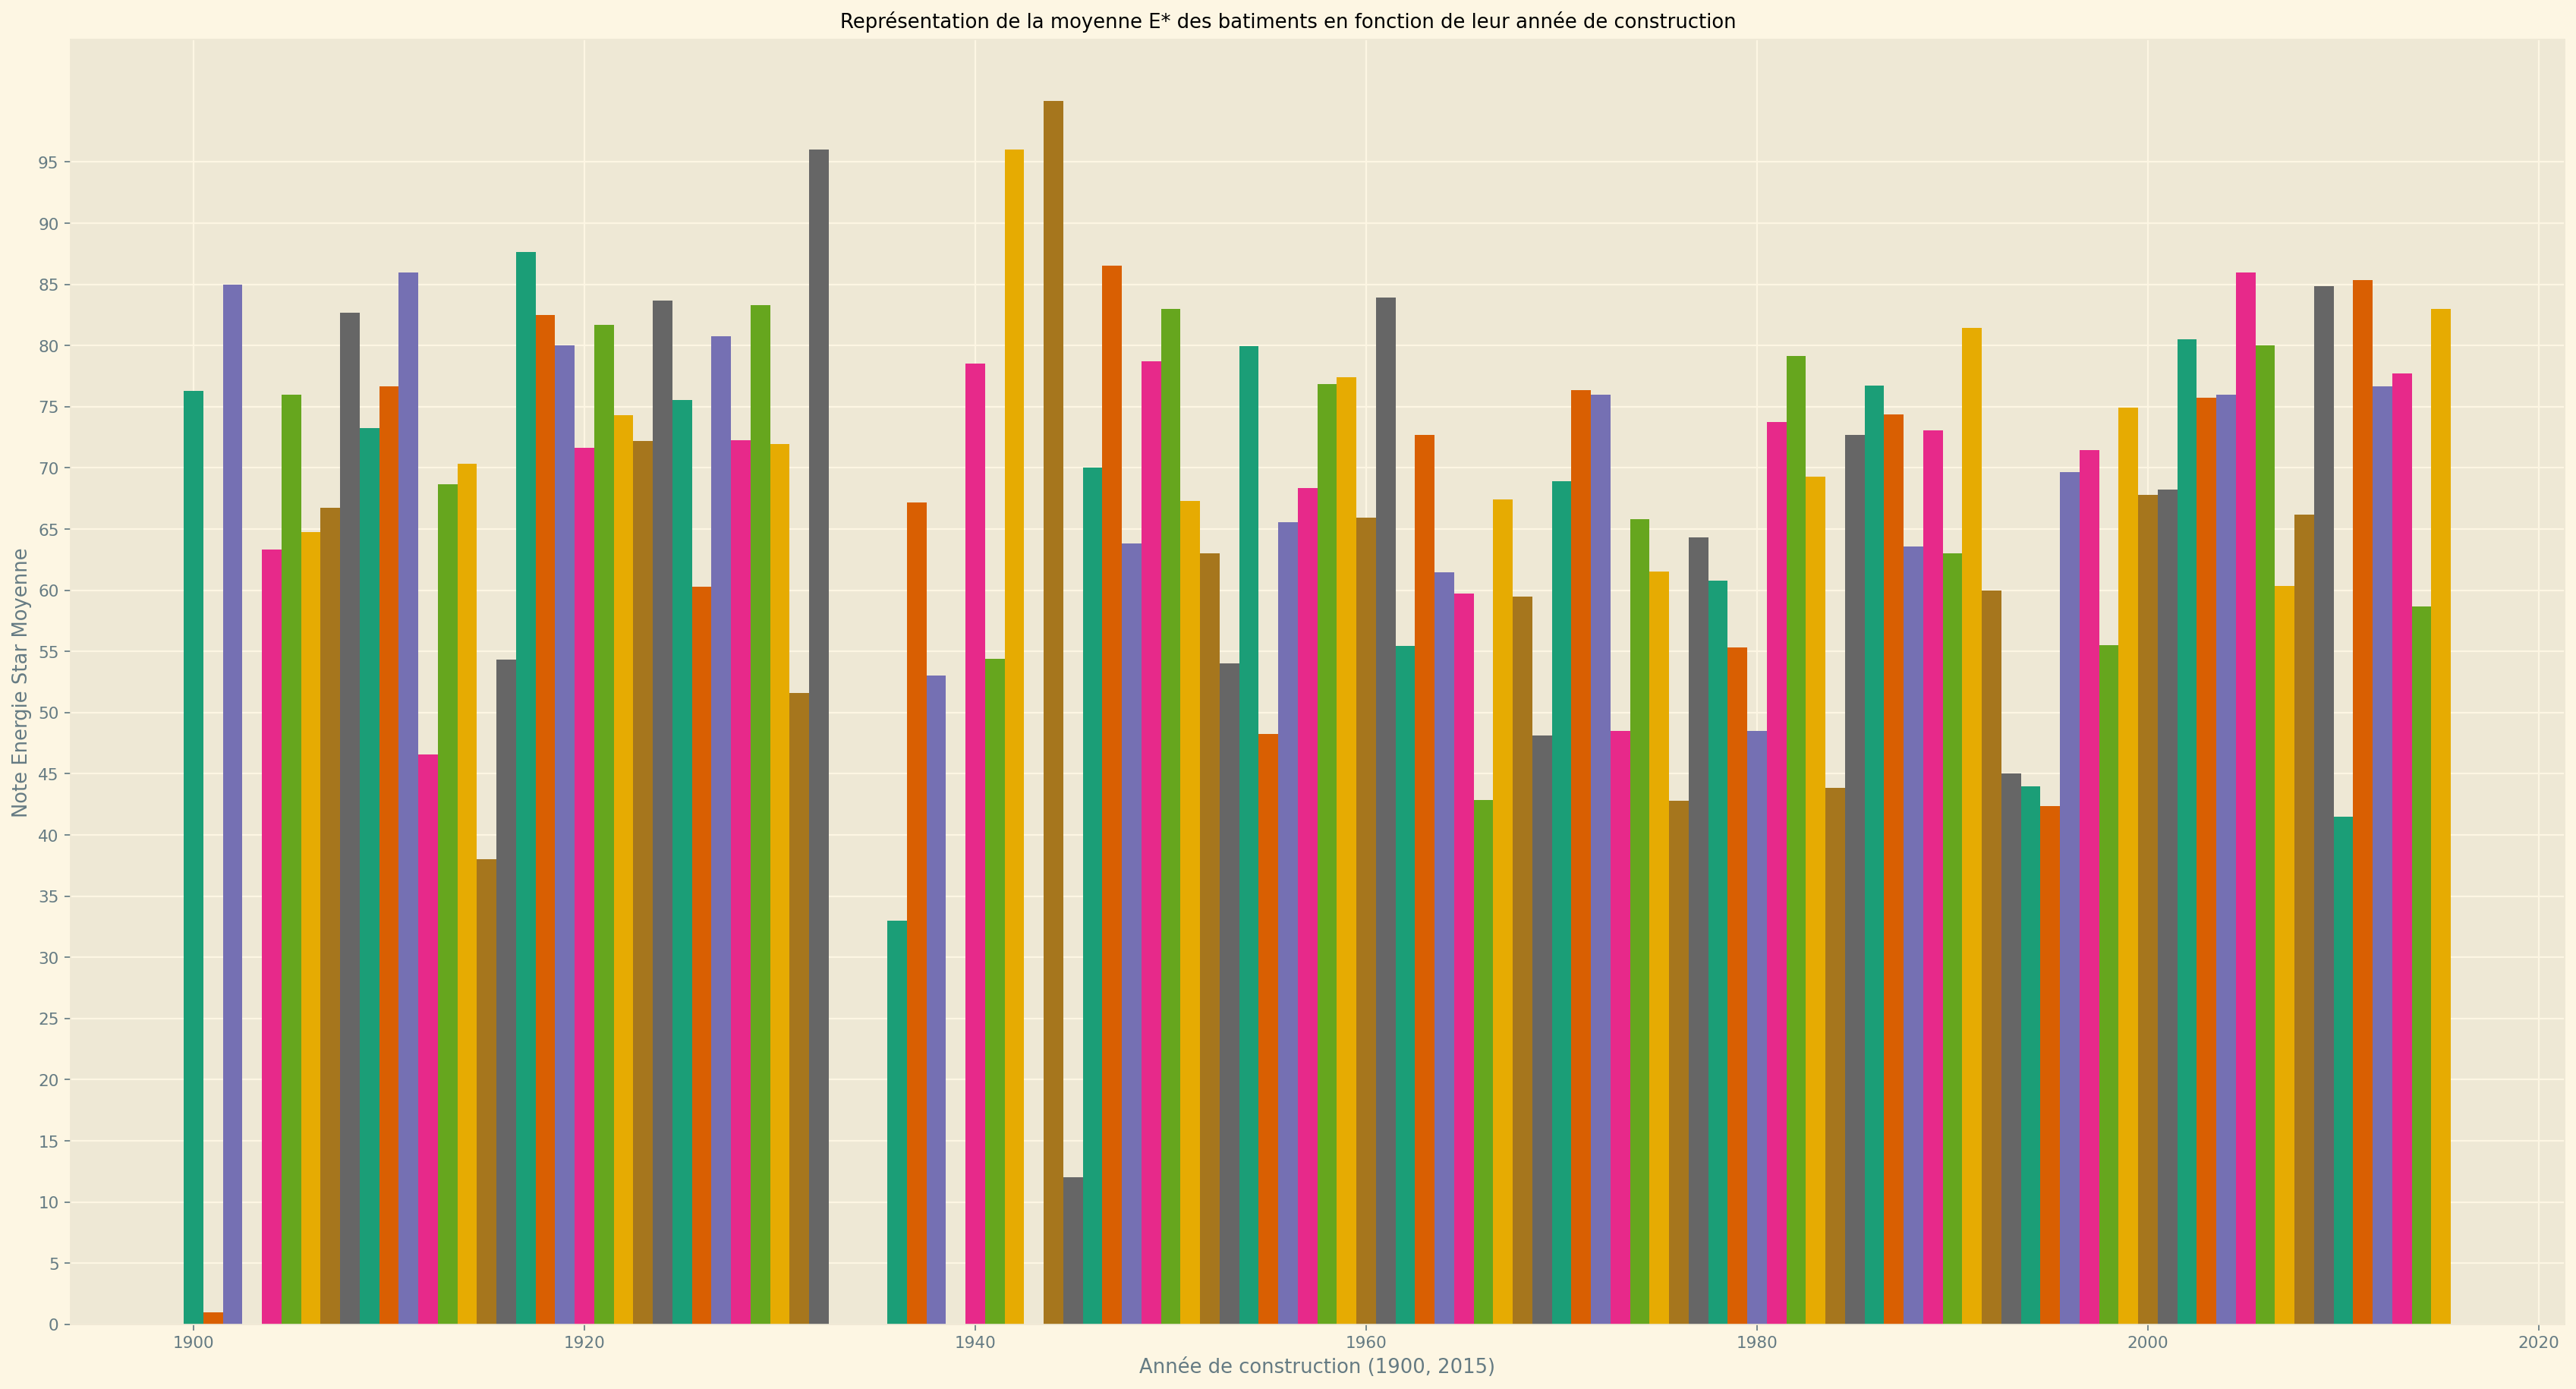

In [15]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 12),
    dpi=pc_dpi,
)

years_list = list(df_seattle[df_seattle["YearBuilt"].notna()]["YearBuilt"].values)
year_keys = []
for year in years_list:
    if year not in year_keys:
        year_keys.append(year)

year_keys.sort()

year_dict = dict.fromkeys(year_keys)

for key in year_dict.keys():
    temp = df_seattle[(df_seattle["YearBuilt"] == key) & (df_seattle["ENERGYSTARScore"].notna())]
    scores = [int(i) for i in temp["ENERGYSTARScore"]]
    try:
        mean = sum(scores) / len(scores)
        year_dict[key] = mean
    except ZeroDivisionError:
        year_dict[key] = 0

ax1.bar(
    x=list(year_dict.keys()),
    height=list(year_dict.values()),
    color=used_cmap.colors,
    width=1,
    )

###
# Titles/Lables
ax1.set_yticks(np.arange(0, 100, 5))
ax1.set_ylabel("Note Energie Star Moyenne")
ax1.set_xlabel("Année de construction (1900, 2015)")
fig.suptitle("Représentation de la moyenne E* des batiments en fonction de leur année de construction")
#
###

fig.tight_layout()
plt.show()


#### Observation :
- L'année de construction ne semble pas de lien clair avec la note E* - Cela peut venir, comme ecrit plus haut, de travaux de modernisation par exemple.

## 3 : Représentation Property Type/Utilisation Energie

<i>On cherche s'il existe des correllations entre les principaux types de batiments et leur note E*| emissions de GES | Intensite d utilisation energetique</i>

### 3.a Visualisation des categories principales

In [16]:
uniques = df_seattle["PrimaryPropertyType"].unique()
unique_ptype_dict = dict.fromkeys(uniques)
for unique in unique_ptype_dict.keys():
    unique_ptype_dict[unique] = len(df_seattle[df_seattle["PrimaryPropertyType"] == unique])

unique_ptype_dict


{'Hotel': 50,
 'K-12 School': 120,
 'Small- and Mid-Sized Office': 230,
 'Large Office': 73,
 'Retail Store': 64,
 'Residence Hall': 18,
 'Other': 7,
 'Warehouse': 140,
 'Worship Facility': 64,
 'Mixed Use Property': 17,
 'Distribution Center': 37,
 'Medical Office': 22,
 'Supermarket / Grocery Store': 4,
 'Refrigerated Warehouse': 5,
 'Senior Care Community': 11,
 'Hospital': 1,
 'Office': 3,
 'Non-Refrigerated Warehouse': 2}

#### Observations :
- SPS -> Seattle Public School
- K12 -> Shool -> from kindergarten to 12th grade
- Typos, doubles espaces etc.
- Pré groupement via généralisation
- La generalisation permettra de creer des categories plus inclusives tout en gardant les propriétes principales des batiments
- Necessité de clarification : Batiments types cités universitaires & campus comptent comme residentiels ?

In [17]:
correction_dict = {
    "Self-Storage Facility\n": "Self-Storage Facility",  # Possibly warehouse
    "Small- and Mid-Sized Office": "Small & Mid-Sized Office",
    "Restaurant\n": "Restaurant",
    "Distribution Center\n": "Supermarket & Grocery store",
    "Distribution Center": "Supermarket & Grocery store",
    "Supermarket/Grocery Store": "Supermarket & Grocery store",
    "Supermarket / Grocery Store": "Supermarket & Grocery store",
    "SPS-District K-12": "K-12 School",
    "Senior Care Community": "Small & Medium medical facility",  # Unsure
    "Laboratory": "Small & Medium medical facility",  # Unsure
    "Medical Office": "Small & Medium medical facility",  # Unsure
    "Small- and Mid-Sized Office": "Small & Mid-Sized Office",
    "Non-Refrigerated Warehouse": "Warehouse",
    "Residence Hall/Dormitory": "Residence Hall",
    "University": "College/University",
    "Retail Store": "Supermarket & Grocery store",
    "Self-Storage Facility": "Warehouse",  # Unsure
}

for key in correction_dict.keys():
    df_seattle["PrimaryPropertyType"].replace(to_replace=key, value=correction_dict[key], inplace=True)

print(df_seattle["PrimaryPropertyType"].value_counts())



Small & Mid-Sized Office           230
Warehouse                          142
K-12 School                        120
Supermarket & Grocery store        105
Large Office                        73
Worship Facility                    64
Hotel                               50
Small & Medium medical facility     33
Residence Hall                      18
Mixed Use Property                  17
Other                                7
Refrigerated Warehouse               5
Office                               3
Hospital                             1
Name: PrimaryPropertyType, dtype: int64


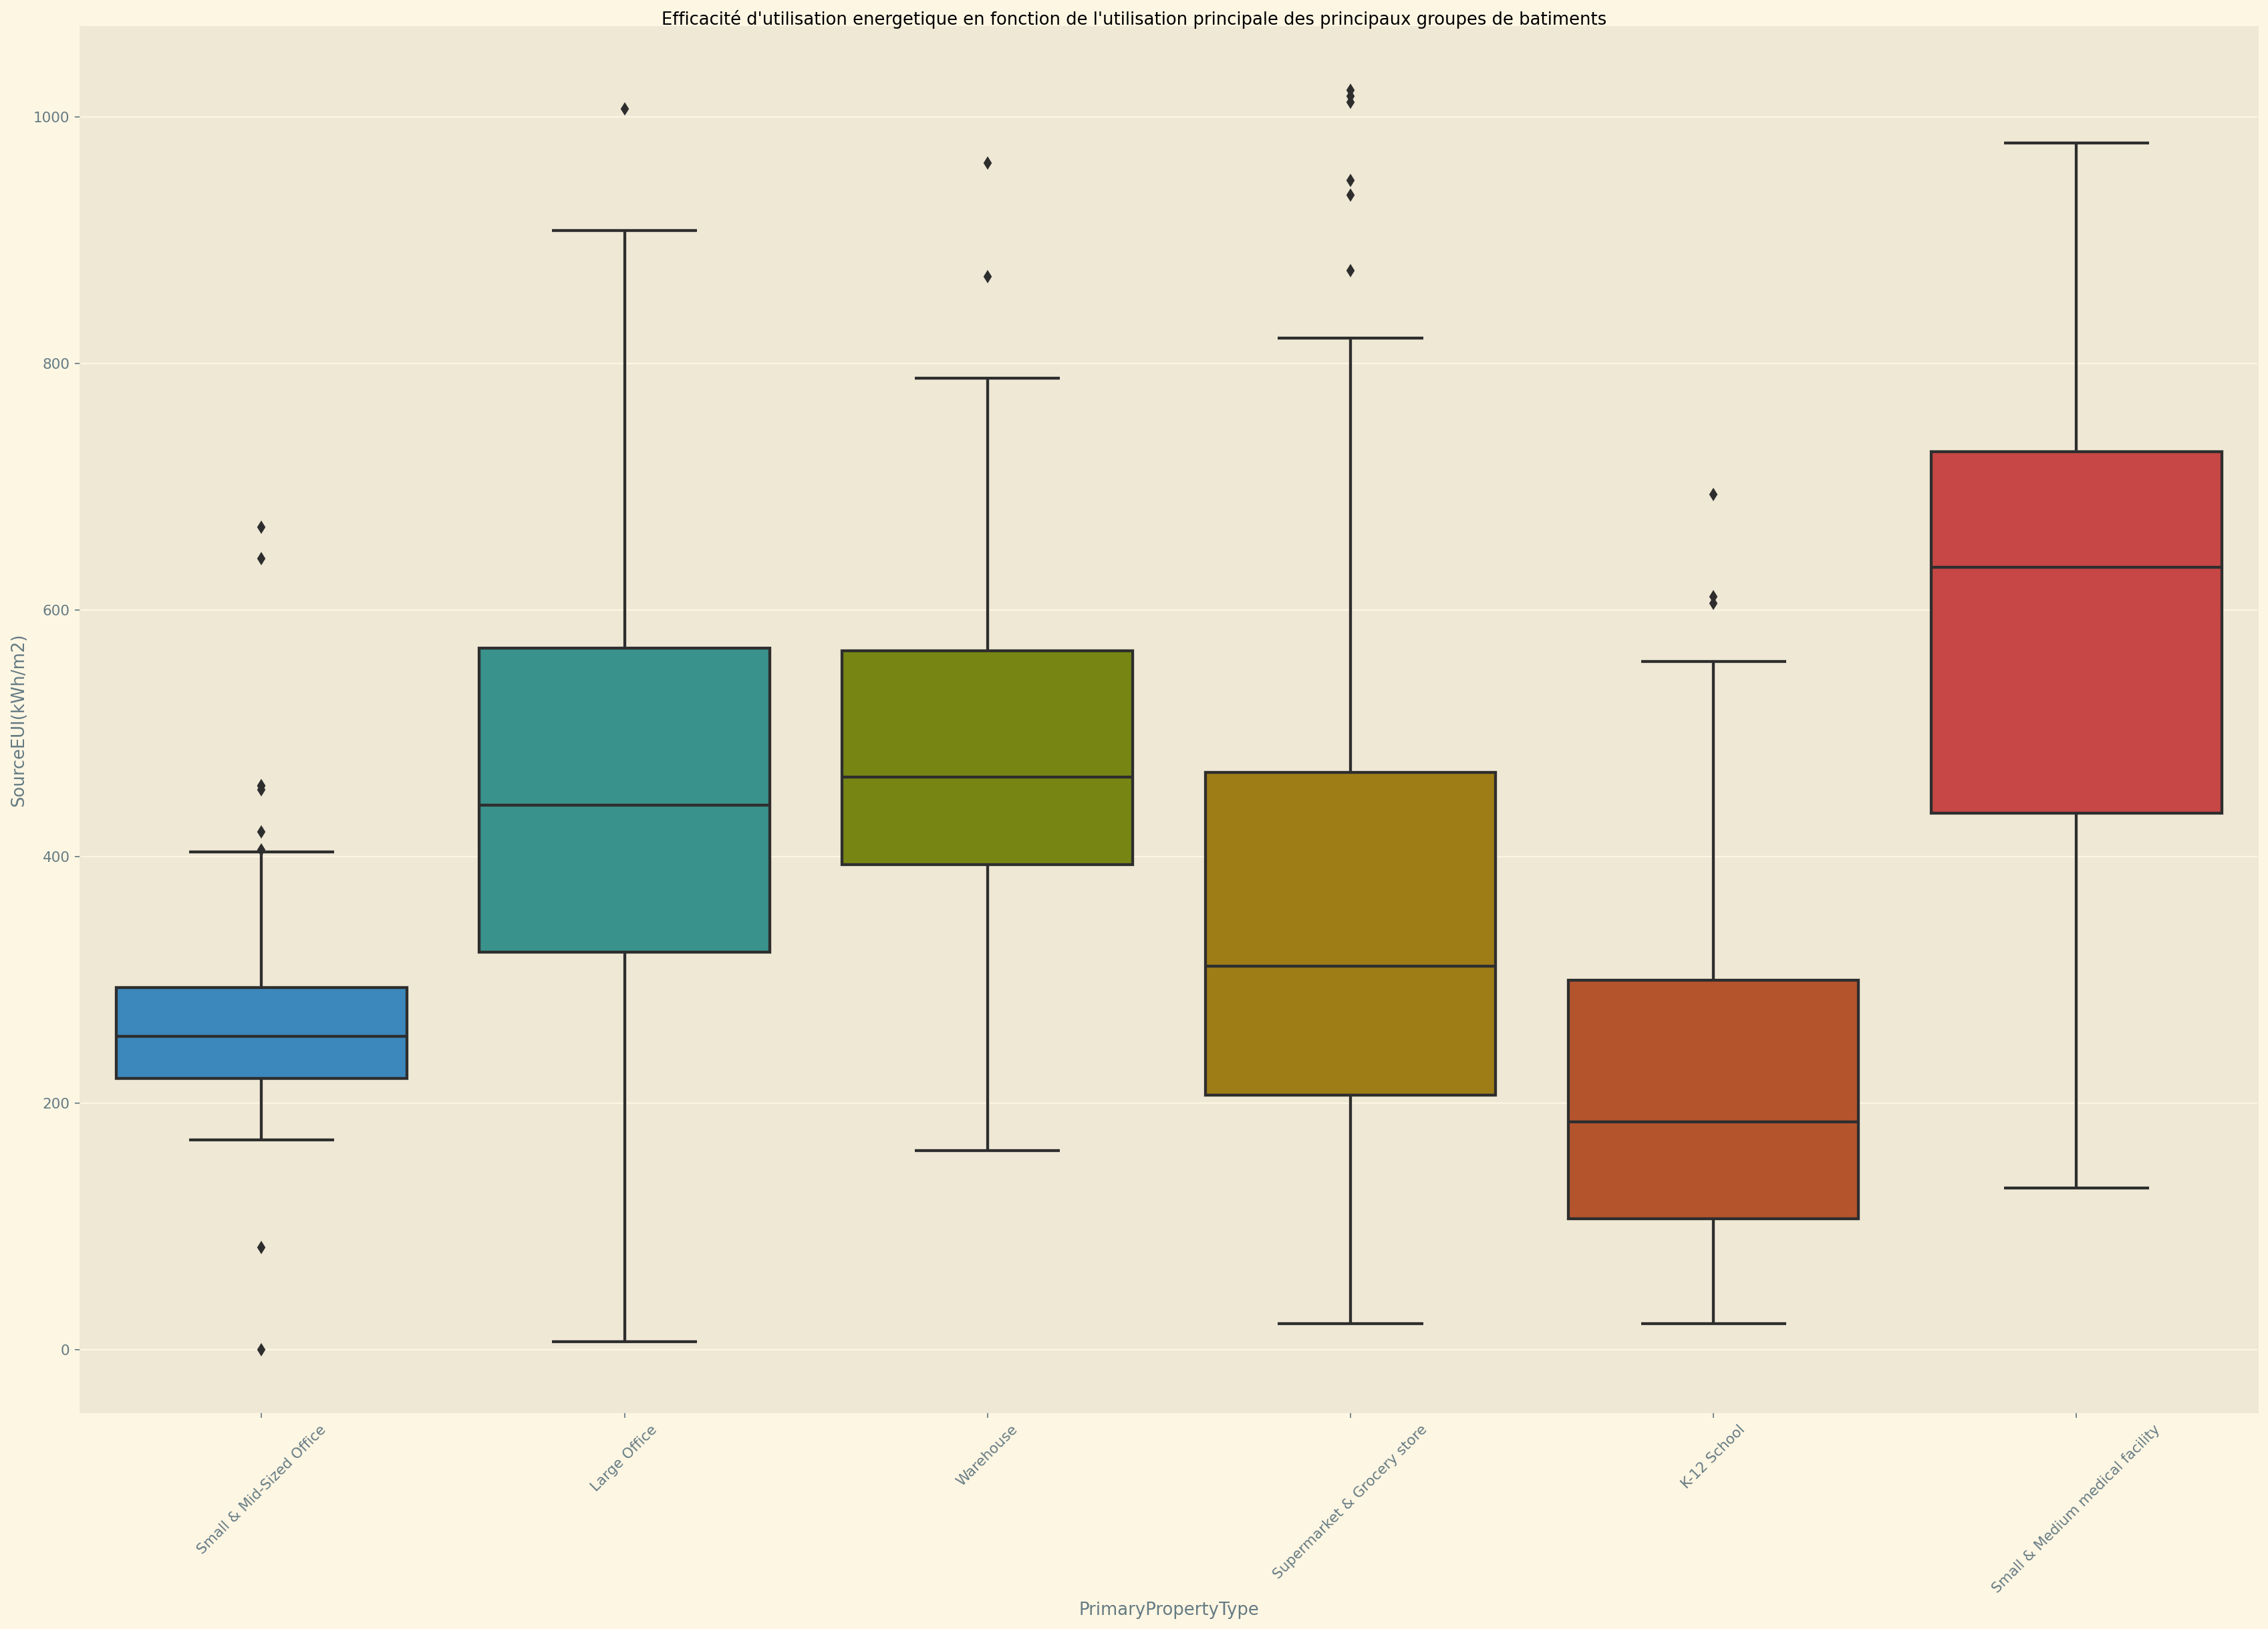

In [18]:
select_six = [
    "Small & Mid-Sized Office", "Large Office", "Warehouse", "Supermarket & Grocery store",
    "K-12 School", "Small & Medium medical facility",
]

# EUI , color code property type, sample based on smallest group size

fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 16),
    dpi=pc_dpi,
)

data_ptype = df_seattle[df_seattle["PrimaryPropertyType"].isin(select_six)]

ax1 = sns.boxplot(
    x=data_ptype["PrimaryPropertyType"],
    y=data_ptype["SourceEUI(kWh/m2)"],
    data=data_ptype
)

###
# Titles/Lables
ax1.set_xticklabels(
    labels=select_six,
    rotation=45
    )
fig.suptitle("Efficacité d'utilisation energetique en fonction de l'utilisation principale des principaux groupes de batiments")

#
###

plt.tight_layout()
plt.show()


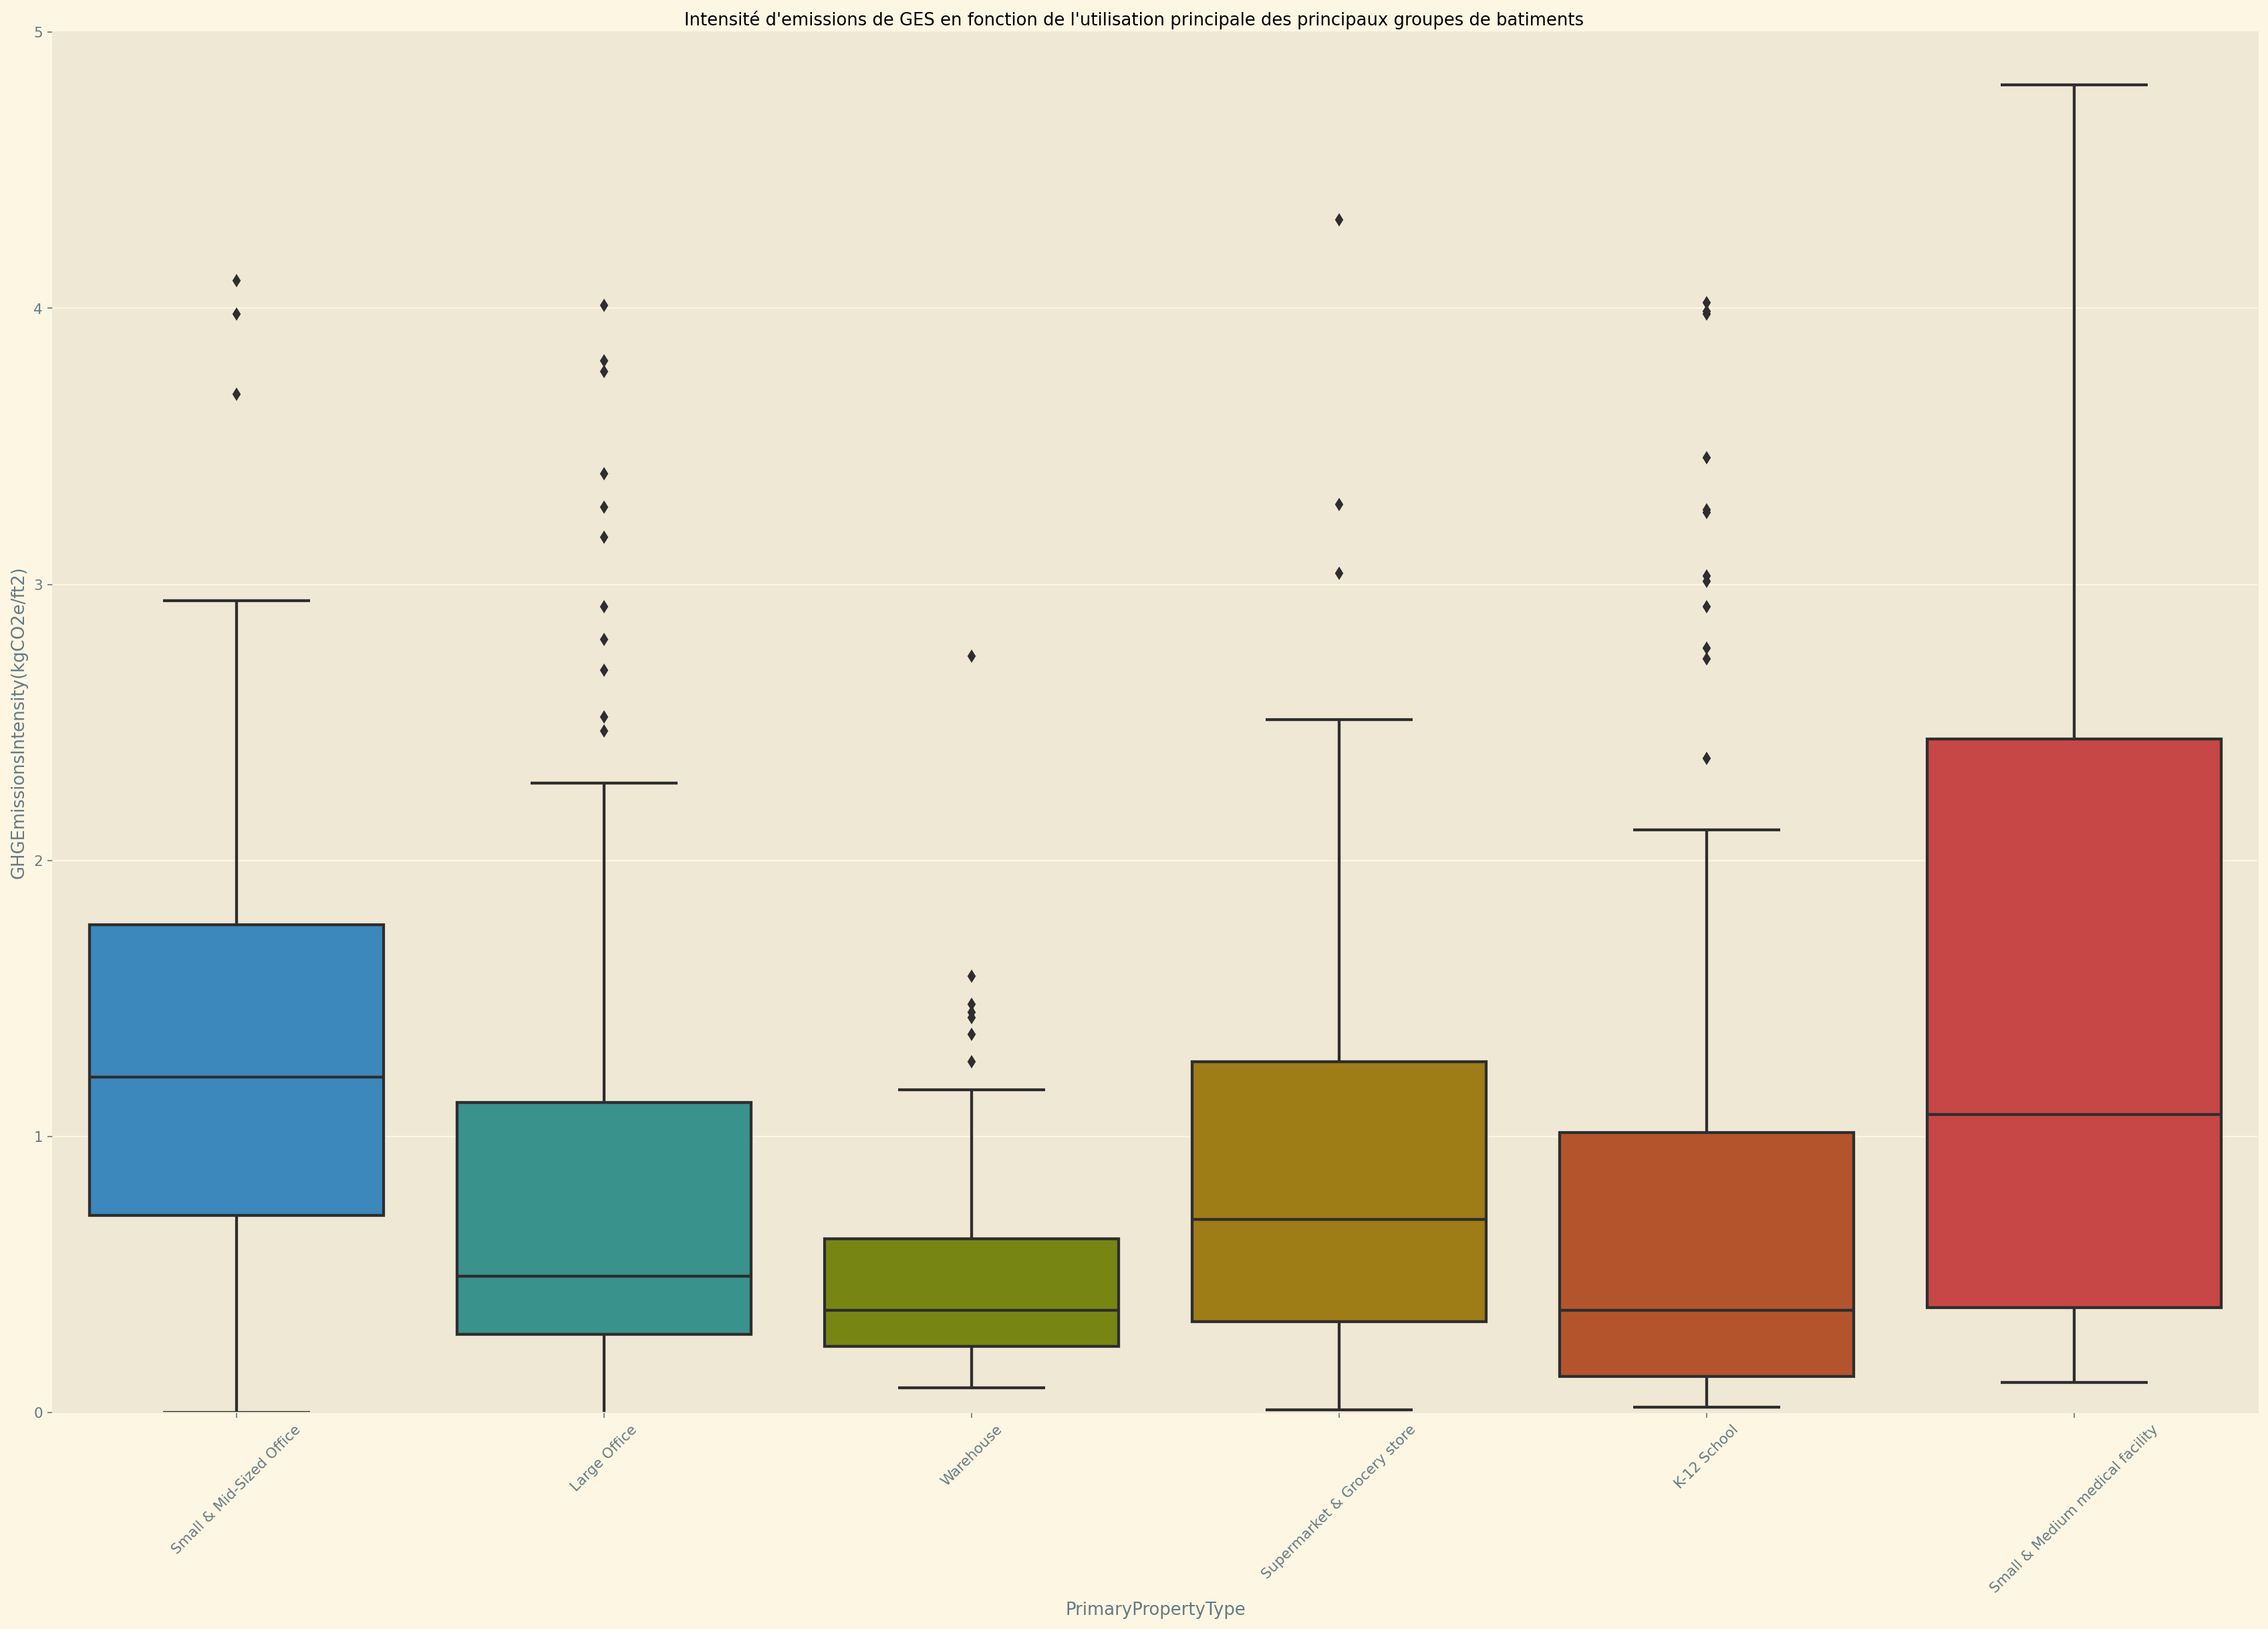

In [19]:
# GES, color code property type, sample based on smallest group size

fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 16),
    dpi=pc_dpi,
)

data_ptype = df_seattle[df_seattle["PrimaryPropertyType"].isin(select_six)]

ax1 = sns.boxplot(
    x=data_ptype["PrimaryPropertyType"],
    y=data_ptype["GHGEmissionsIntensity(kgCO2e/ft2)"],
    data=data_ptype
)

###
# Titles/Lables
ax1.set_xticklabels(
    labels=select_six,
    rotation=45
    )
ax1.set_ylim(0, 5)  # few extremes above
fig.suptitle("Intensité d'emissions de GES en fonction de l'utilisation principale des principaux groupes de batiments")
#
###

plt.tight_layout()
plt.show()


#### Observations :
- On voit que dans les deux cas, la statistique étudiée semble avoir une grande importance sur la repartition de la statistique en question
- Il est possible de realiser deux ANOVAs pour vérifier ces hypotheses :

### ANOVAs :
- On definit alpha sur 0.05 | 5%
- On formulle les hypotheses nulles suivantes : 
  - Les differences observees entre les batiments etudies ne sont pas dus a leur types respectifs (a : pour ce qui est de l'utilisation energetique, b : pour ce qui est de leurs emissions de GES)
- Les criteres de l'ANOVA sont : 
  - 1. La normalité des résidus (test de shapiro sur les residus)
  - 2. Indépendance des échantillons (ce qui est, ici, le cas)
  - 3. Une variance homogène entre les échantillons (on utilisera le test de Bartlett)
- On cherche a invalider les deux hypotheses nulles (H0a et H0b)

In [20]:
alpha = 0.05
α = 0.05  # Double definition for unicode possible errors

anova_dict = dict.fromkeys(select_six)

# Dict w/ key value pair -> key = type, value = tuple, tuple[0] = SourceEUI(kWh/m2), tuple[1] = GHGEmissionsIntensity(kgCO2e/ft2)

for key in anova_dict.keys():
    anova_dict[key] = (
        data_ptype[data_ptype["PrimaryPropertyType"] == key]["SourceEUI(kWh/m2)"].values,
        data_ptype[data_ptype["PrimaryPropertyType"] == key]["GHGEmissionsIntensity(kgCO2e/ft2)"].values
    )

print(anova_dict.keys())


dict_keys(['Small & Mid-Sized Office', 'Large Office', 'Warehouse', 'Supermarket & Grocery store', 'K-12 School', 'Small & Medium medical facility'])


### Tests equal var 1 & 2

In [21]:
bartlett_eui = stats.bartlett(
    anova_dict["Small & Mid-Sized Office"][0],
    anova_dict["Large Office"][0],
    anova_dict["Warehouse"][0],
    anova_dict["Supermarket & Grocery store"][0],
    anova_dict["K-12 School"][0],
    anova_dict["Small & Medium medical facility"][0]
)

print(bartlett_eui)
print(bartlett_eui.pvalue > α)


BartlettResult(statistic=119.30428681833442, pvalue=4.406363753292183e-24)
False


In [22]:
bartlett_ghg = stats.bartlett(
    anova_dict["Small & Mid-Sized Office"][1],
    anova_dict["Large Office"][1],
    anova_dict["Warehouse"][1],
    anova_dict["Supermarket & Grocery store"][1],
    anova_dict["K-12 School"][1],
    anova_dict["Small & Medium medical facility"][1]
)

print(bartlett_ghg)
print(bartlett_ghg.pvalue > α)


BartlettResult(statistic=70.62551606006012, pvalue=7.593449476153952e-14)
False


#### On ne peut pas proceder a une ANOVA dans les deux cas

Le test de Kruskal-Wallis peut etre utilisé par exemple, mais dans ce cas la, on voit clairement que la variable "PrimaryPropertyType" a une influence sur l EUI et intensite de GES. Cette variable est par consequent pertinente pour la creation d'un modele determinant ces deux facteurs

In [23]:
df_seattle


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,LargestPropertyUseType,ENERGYSTARScore,...,GHGEmissionsIntensity(kgCO2e/ft2),PropertyArea(SquareMetre)Total,PropertyArea(SquareMetre)Parking,PropertyArea(SquareMetre)Building(s),LargestPropertyUseTypeArea(SquareMetre),SourceEUI(kWh/m2),SourceEUIWN(kWh/m2),SiteEnergyUse(kWh),SiteEnergyUseWN(kWh),NaturalGas(kWh)
0,1,NonResidential,Hotel,Mayflower park hotel,DOWNTOWN,1927,1,12,Hotel,60.0,...,2.83,8215.787439,0.000000,8215.787439,8215.787439,575.712675,596.217510,2.117838e+06,2.185405e+06,3.740915e+05
1,2,NonResidential,Hotel,Paramount Hotel,DOWNTOWN,1996,1,11,Hotel,61.0,...,2.86,9621.596241,1399.491395,8222.104846,7792.706995,555.523318,565.933427,2.458261e+06,2.539308e+06,1.507875e+06
3,5,NonResidential,Hotel,HOTEL MAX,DOWNTOWN,1926,1,10,Hotel,56.0,...,4.67,5696.814413,0.000000,5696.814413,5696.814413,682.022348,706.628160,1.991296e+06,2.035906e+06,5.308142e+05
5,10,NonResidential,Hotel,Camlin,DOWNTOWN,1926,1,11,Hotel,27.0,...,2.12,7711.695544,0.000000,7711.695544,7557.848110,462.462913,488.015063,1.687736e+06,1.776822e+06,8.638505e+05
9,17,NonResidential,Hotel,Executive Pacific Plaza,DOWNTOWN,1928,1,9,Hotel,48.0,...,5.05,6039.533727,0.000000,6039.533727,6039.533727,484.545043,472.557592,1.933114e+06,1.863557e+06,1.054090e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094,21796,NonResidential,K-12 School,SEATTLE PREP - ADELPHIA,EAST,1905,1,1,K-12 School,72.0,...,0.70,7792.892801,0.000000,7792.892801,7792.892801,219.559464,232.808742,7.442731e+05,8.430835e+05,3.000913e+05
1095,22138,NonResidential,Worship Facility,BRIGHTON PRESBYTERIAN CHURCH,SOUTHEAST,1927,1,2,NaN,100.0,...,0.01,2046.561068,0.000000,2046.561068,NaN,41.325129,45.110637,2.696137e+04,2.931297e+04,0.000000e+00
1096,22441,NonResidential,Small & Mid-Sized Office,DEPT OF SOCIAL & HEALTH SERVICES,BALLARD,1979,1,2,Office,88.0,...,1.00,3479.033042,0.000000,3479.033042,3479.033042,566.564364,561.201561,7.466227e+05,7.792755e+05,1.787602e+05
1097,23163,NonResidential,Small & Medium medical facility,LESCHI CENTER,DOWNTOWN,1995,1,4,Medical Office,76.0,...,0.11,4070.360892,2144.759581,1925.601310,4194.107741,394.639209,394.639209,5.272053e+05,5.272053e+05,0.000000e+00


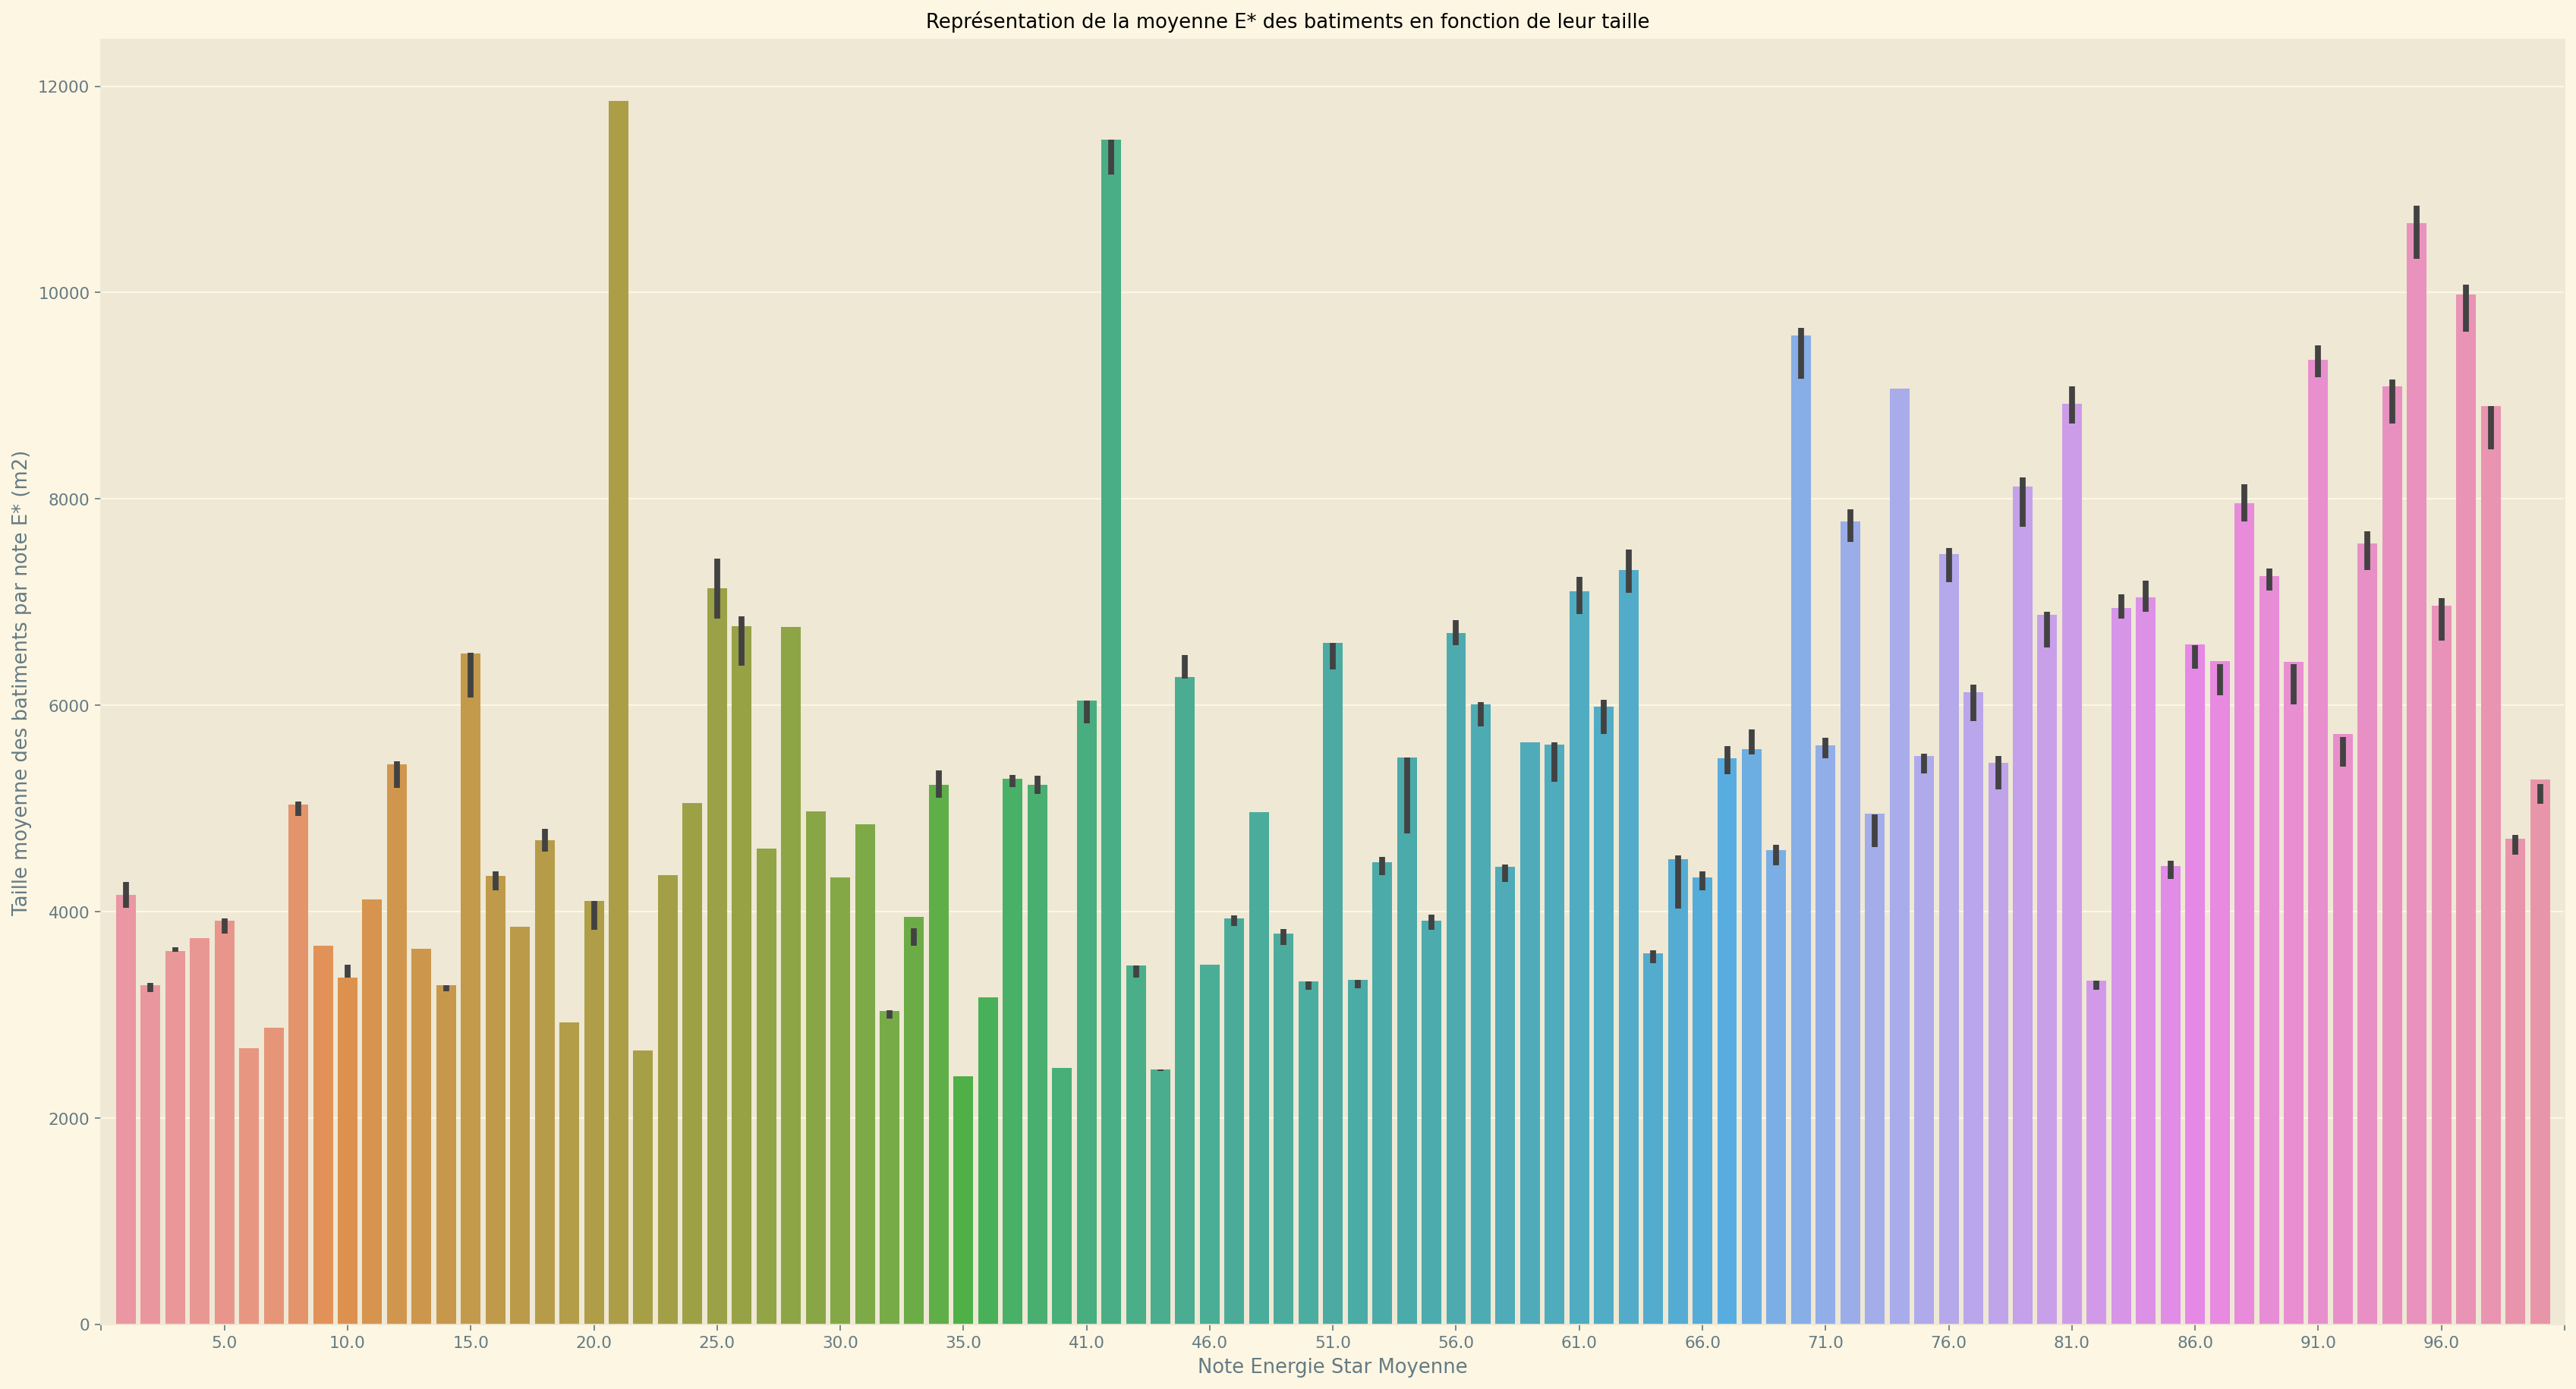

In [24]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 12),
    dpi=pc_dpi,
)

ax1 = sns.barplot(
    x="ENERGYSTARScore",
    y="PropertyArea(SquareMetre)Total",
    data=df_seattle,
    ci=10
)


###
# Titles/Lables
ax1.set_xticks(np.arange(-1, 100, 5))
ax1.set_xlabel("Note Energie Star Moyenne")
ax1.set_ylabel("Taille moyenne des batiments par note E* (m2)")
fig.suptitle("Représentation de la moyenne E* des batiments en fonction de leur taille")
#
#
###

fig.tight_layout()
plt.show()


#### Observations : 
On ne peut pas etablir a visuellement une correllation claire entre la taille d'un batiment et sa note. La repartition ne semble obeir a aucune regle de distribution particuliere. L'interet est la combinaison Type et Size (meme type mais batiment plus gard = moins efficace energetiquement)

<hr>

## Export pour feature engineering :
- Pour eviter la redondance d'information du modele, on excluera les variables permettant de calculer directement l intensite d emission de GES et d utilisation energetique, a savoir :
  - SourceEUIWN, PropertyArea(SquareMetre)Total', 'PropertyArea(SquareMetre)Parking', 'PropertyArea(SquareMetre)Building(s)', LargestPropertyUseTypeArea(SquareMetre)
    - --> Ces variables permettent de calculer manuellement les valeurs cibles
  - Les valeurs cibles seront : SourceEUI(kWh/m2) & GHGEmissionsIntensity(kgCO2e/ft2)
- Elimination des redondances : PrimaryPropertyType & BuildingType & LargestPropertyUseType (Building type est moins divers et sera exclu)
- PropertyName n est pas utile

<hr>

In [25]:
df_seattle.columns


Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'LargestPropertyUseType', 'ENERGYSTARScore', 'Electricity(kWh)',
       'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'PropertyArea(SquareMetre)Total', 'PropertyArea(SquareMetre)Parking',
       'PropertyArea(SquareMetre)Building(s)',
       'LargestPropertyUseTypeArea(SquareMetre)', 'SourceEUI(kWh/m2)',
       'SourceEUIWN(kWh/m2)', 'SiteEnergyUse(kWh)', 'SiteEnergyUseWN(kWh)',
       'NaturalGas(kWh)'],
      dtype='object')

In [26]:
cols_discard = [
        "BuildingType", "PropertyName", "LargestPropertyUseType",  # *1
        "GHGEmissions(MetricTonsCO2e)", "SourceEUIWN(kWh/m2)", "SiteEnergyUse(kWh)", "SiteEnergyUseWN(kWh)", # *2
        ]

columns_keep = [col for col in df_seattle.columns if col not in cols_discard]

df_export_one = df_seattle[columns_keep].copy()
df_raw_data = df_seattle[columns_keep].copy()

# *1 : redundancies or useless : BTypes +|- = PrimaryPropertyType, 
# LargestPropertyUseType overlap w/ PropertyArea(SquareMetre)Total
# name = useless

# *2 Avoiding data leaks

df_raw_data.set_index("OSEBuildingID", inplace=True)

df_raw_data.to_csv("./data/seattle_raw_data.csv", sep=",")
